# Compressed Sensing Project
By: Georges SARR and Hamdi BEL HADJ HASSINE

## Paper 1: CONVEX RELAXATIONS OF CONVOLUTIONAL NEURAL NETS$^{[1]}$

### One node problem
Let the problem (1) \begin{align} w^{*} \in \text{argmin}_{w\in \mathbb{R}^d} \frac{1}{n}||\sigma(Xw) - Y||^2_2 \end{align} where $X = \begin{pmatrix}x_1^T \\ . \\.\\.\\x_n^T \end{pmatrix} \in \mathbb{R}^{n\times d}$, $Y=\begin{pmatrix}y_1 \\ . \\.\\.\\y_n \end{pmatrix} \in \mathbb{R}^{n}$, and $\sigma(Xw)$ designates the vector whose coordinates are the pointwise values of $\sigma$ (the activation function) at the coordinates of $Xw$. This problem can be seen as a nonlinear regression problem.

This problem (1) is NP-hard in general for the ReLU activation function. In fact one can show that there is one special case of the One Node Relu problem (that is problem (1) with ReLU activation function) which can be reduced to the \{$\pm$\} subset sum problem, an NP-hard version of the subset sum problem.

### Naive relaxation


Problem (1) can be naively relaxed by introducing slack variable Z as in (2):

\begin{align}w^{**}, Z^{**}  \in \text{argmin}_{w\in \mathbb{R}^d, Z \in \mathbb{R}^n} \frac{1}{n}||Z - Y||^2_2 \;  \text{s.t.} \; Z \geq \sigma(Xw)\end{align}

One major problem is that the relaxed problem does not necessarily yield a solution for the initial problem. Let us illustrate this numerically. To do so we rewrite the relaxed One Node ReLU problem in the default Quadratic Program format used by most solvers: $\min \frac 1 2 x^T P x + q^T x \quad s.t. \quad Gx \leq h$:

\begin{equation*}
w^{**},  Z^{**}   \in \text{argmin}_{w\in \mathbb{R}^d, Z \in \mathbb{R}^n} \frac{1}{2}  \begin{pmatrix}w \\ Z \end{pmatrix}^T \underbrace{\begin{pmatrix}0 & 0\\ 0 & 2I_n \end{pmatrix}}_{\in \; \mathbb{R}^{(n+d) \times (n+d)} }  \begin{pmatrix}w \\ Z \end{pmatrix} + \begin{pmatrix}0 \\ -2Y \end{pmatrix}^T \begin{pmatrix}w \\ Z \end{pmatrix} \text{s.t.} \underbrace{\begin{pmatrix}  0 & -I_n \\ X & -I_n \end{pmatrix}}_{\in \mathbb{R}^{2n \times (n+d)}} \begin{pmatrix}w \\ Z \end{pmatrix} \leq 0
\end{equation*}

In [1]:
#!pip install cvxopt
#!pip install cvxpy
import os, sys
#sys.path.insert(0, os.path.expanduser('~/.local/lib/python3.8/site-packages'))
from cvxopt import matrix, solvers
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from matplotlib import cm
import seaborn as sb
import pickle
import itertools

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image

In [2]:
np.random.seed(1)

d=10 # number of features (explanatory variables)
n = 1000 # number of inputs, shouldn't be too high otherwise the solvers' RAM usage exceeds the available RAM
mean = [0]*d # mean of a multivariate gaussian
cov = np.eye(d) # covariance matrix of a multivariate gaussian

w_star = np.random.randn(d)  # should be the solution found by the solver

X = np.random.multivariate_normal(mean, cov, n)
Y = (abs(X@w_star)+X@w_star)/2

P = np.zeros((n+d, n+d))
P[-n:,-n:] = 2*np.eye(n)
q = np.zeros(n+d)
q[-n:] = -2*Y

G = np.zeros((2*n, n+d))
G[:n, d:] = -np.eye(n)
G[n:,d:] = -np.eye(n)
G[n:, :d] = X
h = np.array([0.0]*(2*n))

solution = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h))

     pcost       dcost       gap    pres   dres
 0: -6.0959e+03 -1.6009e+04  4e+04  9e+01  6e+00
 1: -6.5471e+03 -1.1463e+04  5e+03  6e+00  4e-01
 2: -7.2719e+03 -7.7890e+03  5e+02  3e-14  7e-16
 3: -7.4118e+03 -7.4633e+03  5e+01  3e-14  2e-16
 4: -7.4267e+03 -7.4338e+03  7e+00  2e-14  6e-17
 5: -7.4289e+03 -7.4298e+03  9e-01  3e-14  5e-17
 6: -7.4292e+03 -7.4293e+03  1e-01  2e-14  5e-17
 7: -7.4292e+03 -7.4292e+03  2e-02  2e-14  5e-17
 8: -7.4292e+03 -7.4292e+03  2e-03  3e-14  5e-17
Optimal solution found.


In [3]:
# Obtained solution
w = np.array(solution['x'][:10])
w

array([[ 0.78938399],
       [-0.30259383],
       [-0.27180085],
       [-0.53788026],
       [ 0.40919976],
       [-1.13479348],
       [ 0.85785893],
       [-0.35216133],
       [ 0.15522792],
       [-0.13268559]])

In [4]:
# Correct solution
w_star

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038])

In [5]:
# Objective function at the obtained solution:
x = np.array(solution['x'])
1/2*x.T@P@x + q.T@x

array([[-7429.22531092]])

In [6]:
# Objective function at the correct solution:
x_star = x.copy()
x_star[:d,0] = w_star
x_star[d:,0] = Y
1/2*x_star.T@P@x_star + q.T@x_star
# Almost equal to that of the obtained solution. If the solver used infinite iterations, this would equal the objective at the obtained solution

array([[-7429.22640822]])

We see that the solver didn't converge to the desired solution $w^*$, although it did converge to another solution achieving the same objective value. This illustrates that the relaxed problem doesn't have only one solution, but multiple global minima. This is because the $P$ matrix of this quadratic program is only Positive Semi-Definite, and not Positive Definite. As a result, although the problem is convex and any solver can converge to *one* of the global minima, we have no guarantees that it converges to the correct solution of the original problem (1).

We try again using other solvers:

In [7]:
solution=dict()
error_solver = []
for solver in ["OSQP", "SCS", "ECOS"]:
    # Define and solve the problem
    x = cp.Variable(n+d)
    constraints=[G @ x <= h]
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T @ x), constraints)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            print(solver ,":")
            prob.solve(solver=solver)
            w_solution = x.value[:d] ; z_solution = x.value[d:]
            solution[solver] = {"w":w_solution, "z":z_solution}
            opt_obj = 1/2*x.value.T@P@x.value + q.T@x.value # or np.sum((z_solution - Y)**2) # Final value of the objective function
            print("Final value of the objective function: {}".format(opt_obj))
            print("Final value of w**:")
            print(w_solution)
            dist_w_s_and_w_ss = np.sqrt(np.sum((w_star-w_solution)**2))
            print("Euclidian distance between w* and w**: {} \n".format(dist_w_s_and_w_ss))
    except:
        print("solver failed \n")
        error_solver.append(solver)

OSQP :
Final value of the objective function: -7429.226408224385
Final value of w**:
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Euclidian distance between w* and w**: 3.7784596252633174 

SCS :
Final value of the objective function: -7429.152603535956
Final value of w**:
[ 0.85873468 -0.32428147 -0.29890494 -0.63997338  0.42202302 -1.16332784
  0.85653674 -0.3925642   0.09043038 -0.1226312 ]
Euclidian distance between w* and w**: 1.8423404383407047 

ECOS :
Final value of the objective function: -7429.226396477163
Final value of w**:
[ 0.79518702 -0.30690004 -0.27374072 -0.54441849  0.4123448  -1.13937921
  0.86094424 -0.35618642  0.15284433 -0.13271769]
Euclidian distance between w* and w**: 1.9149187688816844 



In [8]:
# Objective value of problem (1) for the found solutions
for solver in ["OSQP", "SCS", "ECOS"]:
    print(1/n*np.sum((np.maximum(X@solution[solver]["w"],0) - Y)**2))

7.429226408224384
1.7814432387747547
1.9103362739982364


We see that all solvers converge to a global minimum of the relaxed problem (2) (sometimes the trivial solution w**=0, sometimes other solutions), but their solutions do not solve the original problem (1).

### Randomized relaxation

As illustrated is the previous section, it seems hopeless to find the optimal solution for problem (1) using the relaxed problem (2) which has an infinity of global minima. A solution proposed by the authors of the paper [1] is to fix a random standard gaussian vector $r\sim \mathcal{N}(0,I_d)$ and solve (3):

\begin{align}
w^{***}, Z^{***} \in \text{argmin}_{w\in \mathbb{R}^d, Z \in \mathbb{R}^n} \frac{1}{2}|| Z -Y ||_2^2 + \beta r^T w \; \; \; \text{s.t.}   \; \;Z \geq \sigma(Xw)
\end{align}

where $\beta >0$ is a regularization hyperparameter that accounts for the amount of randomness allowed in the problem. 

In order to solve the problem, let us adopt the following formulation

\begin{equation}
w^{***},  Z^{***}  \in \text{argmin}_{w\in \mathbb{R}^d, Z \in \mathbb{R}^n} \frac{1}{2}\bigg|\bigg|A  \begin{pmatrix}w \\ Z \end{pmatrix} - Y \bigg|\bigg|_2^2 + \beta r^T w \; \;\text{s.t.} \; \; G\begin{pmatrix}w \\ Z \end{pmatrix} \leq 0 \nonumber
\end{equation}

where $A = \begin{pmatrix}0 & I_n \end{pmatrix} \in \mathbb{R}^{n \times (n+d)} $ and $G= \begin{pmatrix}  0 & -I_n \\ X & -I_n \end{pmatrix} \in \mathbb{R}^{2n \times (n+d)}$.

To start with, let us experiment this relaxation by solving it with different values of $\beta$.


In [18]:
betas=[1, 1e-3, 1e-5]
eps =1e-4 # tolerance parameter
N=1000 # number of times to run the solver
nb_found_sol=0
nb_errors=0
n_run=5

d=10 # number of features (explaining variables)
mean = [0]*d # mean of a multivariate gaussian
cov = np.eye(d) # covariance matrix of a multivariate gaussian
n = 1000 # number of inputs

w_star = np.random.randn(d)  # should be the solution found by the solver
X = np.random.multivariate_normal(mean, cov, n)
Y = (abs(X@w_star)+X@w_star)/2

A = np.zeros((n, d+n))
A[:,d:]=np.eye(n)

G = np.zeros((2*n, n+d))
G[:n, d:] = -np.eye(n)
G[n:,d:] = -np.eye(n)
G[n:, :d] = X

h = np.array([0.0]*(2*n))

warnings.simplefilter("ignore")
success_rates=[]
bt=[]
for beta in tqdm(betas):
    for _ in range(n_run):
        bt.append(beta)
        nb_found_sol=0 # number of times the solver finds the desired solution
        nb_errors=0  # number of failures of the solver
        for __ in range(N):
          r = np.random.randn(d)
          c = np.array([0]*(d+n))
          c[:d] = r

          x = cp.Variable(n+d)
          cost = sum([0.5*cp.sum_squares(A @ x - Y) , beta * c@x])
          constraints=[G @ x <= h]
          prob = cp.Problem(cp.Minimize(cost), constraints)
          try:
            prob.solve(solver="OSQP")
            norm1=np.linalg.norm(x.value[:d] - w_star, ord=1)
            norm2=np.linalg.norm(x.value[:d] - w_star, ord=2)
            if norm1<eps or norm2<eps : nb_found_sol+=1
          except: nb_errors+=1
        success_rates.append(100*nb_found_sol/(N-nb_errors))

100%|██████████| 3/3 [1:49:14<00:00, 2184.69s/it]


Text(0, 0.5, '100 * rate of success')

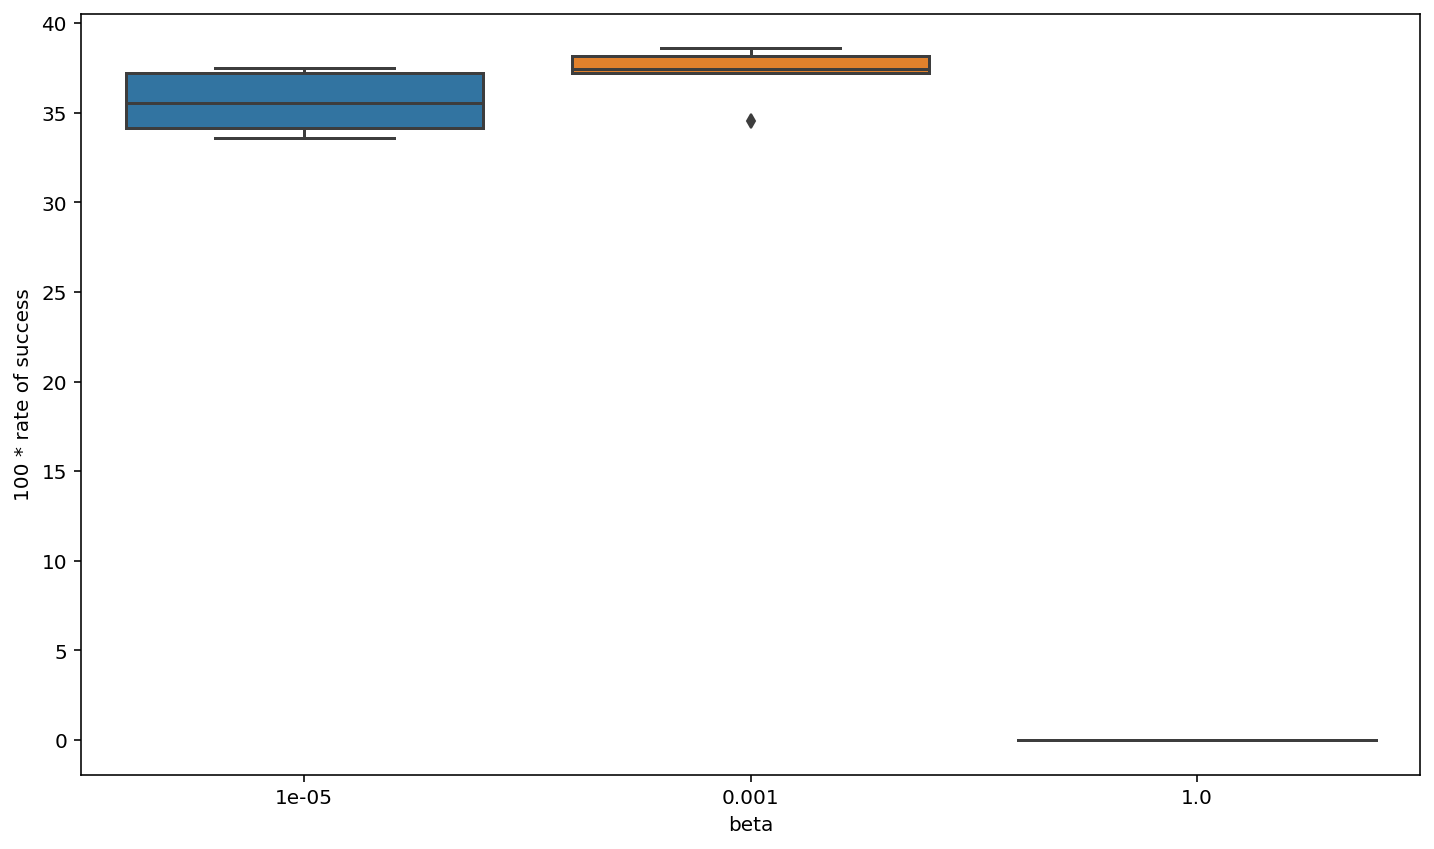

In [19]:
plt.figure()
sb.boxplot(x=bt, y=success_rates)
plt.xlabel('beta')
plt.ylabel('100 * rate of success')
# plt.grid(True)

It seems that as $\beta \rightarrow 0$, the probability to retrieve the solution of problem (1) gets higher.

Now let us solve problem (2) for different values of $n$ and $d$.

In [27]:
def run_random_relax(n_s, d_s, beta=1e-5,eps=1e-6, N=100):

  results = {"beta": [], "eps":[], "N": [], 
            "n": [], "d":[], "100*proba": [], "100*min_error": []}
  l_n_s = len(n_s)
  l_d_s = len(d_s)
  cart_prod=itertools.product(*[n_s, d_s])
    
  for n,d in tqdm(cart_prod, total=l_n_s*l_d_s):
    # Generating the data
    mean = [0]*d 
    cov = np.eye(d) 
    
    w_star = np.random.randn(d) 
    X = np.random.multivariate_normal(mean, cov, n)
    Y = (abs(X@w_star)+X@w_star)/2  

    # Building the objective function and the constraints
    A = np.zeros((n, d+n))
    A[:,d:]=np.eye(n)
    
    G = np.zeros((2*n, n+d))
    G[:n, d:] = -np.eye(n)
    G[n:,d:] = -np.eye(n)
    G[n:, :d] = X 

    h = np.array([0.0]*(2*n))             

    nb_found_sol=0
    nb_errors=0
    error=[]
    for _ in range(N):
      r = np.random.randn(d)
      c = np.array([0]*(d+n))
      c[:d] = r

      x = cp.Variable(n+d)
      cost = sum([0.5*cp.sum_squares(A @ x - Y) , beta * c@x]) #objective function
      constraints=[G @ x <= h]
      prob = cp.Problem(cp.Minimize(cost), constraints)
      try:
        prob.solve(solver="OSQP")    
        norm1=np.linalg.norm(x.value[:d] - w_star, ord=1)
        norm2=np.linalg.norm(x.value[:d] - w_star, ord=2)
        error.append(norm2)
        if norm1<eps or norm2<eps : nb_found_sol+=1
      except: nb_errors+=1

    if N-nb_errors>0:
      results["100*proba"].append(100*nb_found_sol/(N-nb_errors))
      results["n"].append(n)
      results["d"].append(d)
      results["beta"].append(beta)
      results["N"].append(N)
      results["eps"].append(eps)    
      results["100*min_error"].append(100*min(error))
  return results

In [28]:
### Illustrating phase transition for the ONE NODE RELU randomized relaxation problem
warnings.simplefilter("ignore")
min_n = 100
max_n = 1001
min_d = 5
max_d = 50
step_d = 5
step_n = 100

save=True

ax_n = np.arange(min_n, max_n, step_n)
ax_d = np.arange(min_d, max_d, step_d)

if not os.path.isfile('./one_node_relu_random_relax.pickle'):
    res = run_random_relax(ax_n, ax_d, N=50)
    if save: 
        with open('./one_node_relu_random_relax.pickle', 'wb') as outp:
            pickle.dump(res, outp, pickle.HIGHEST_PROTOCOL)

100%|██████████| 90/90 [58:56<00:00, 39.29s/it] 


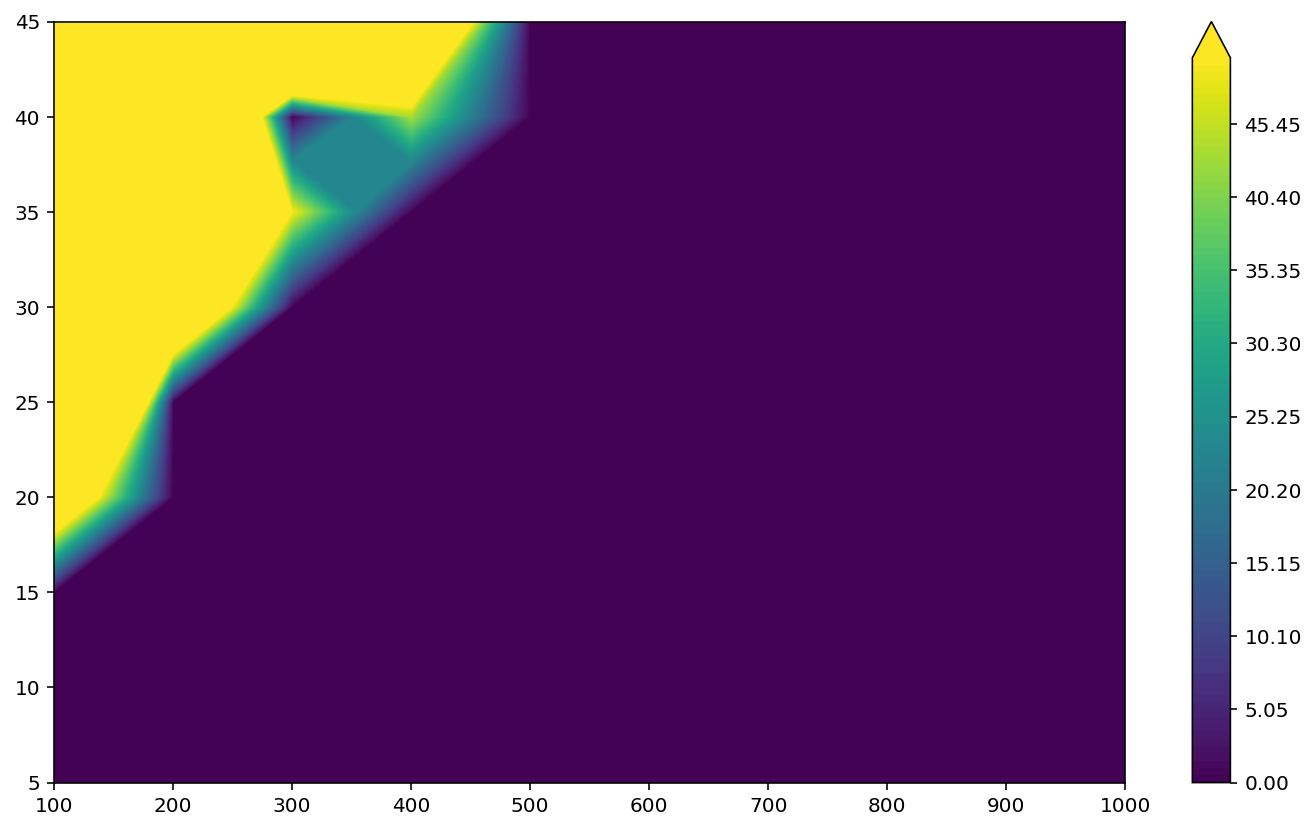

In [47]:
a = plt.contourf(np.array(res['n']).reshape(len(ax_n),len(ax_d)),
            np.array(res['d']).reshape(len(ax_n),len(ax_d)),
            np.array(res["100*min_error"]).reshape(len(ax_n),len(ax_d)), extend='max',
           #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100)
                )
plt.colorbar(a)

This shows that for a given number $d$ of features, when the sample size $n$ gets larger, the solution of the randomized relaxation gets closer to the true parameter $w^{*}$

### CNN randomized relaxation

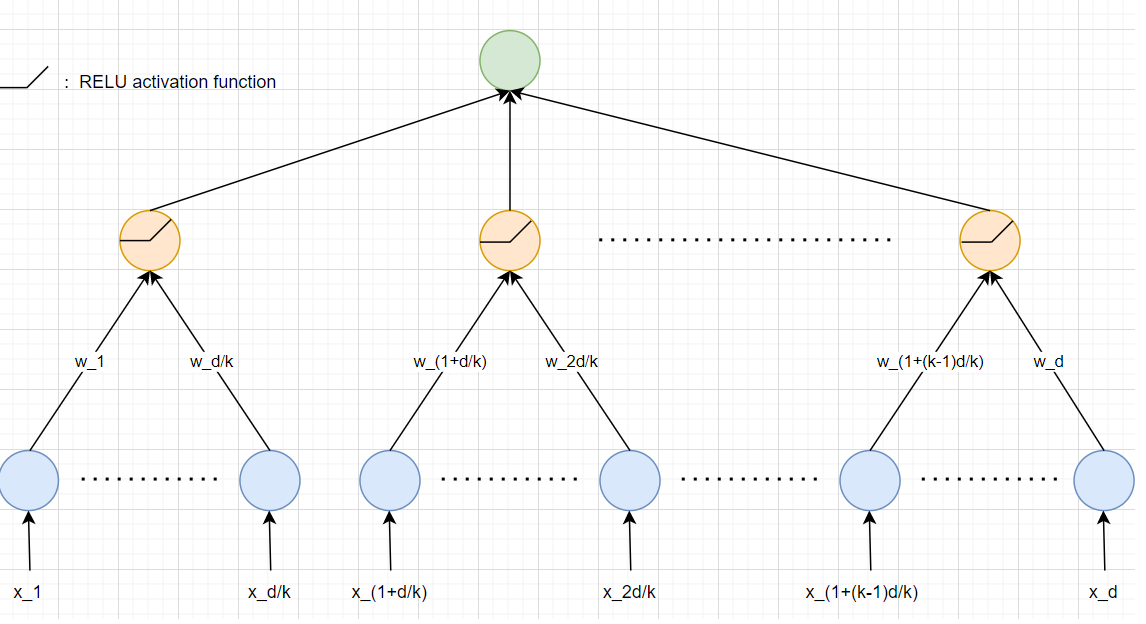

The idea is to add a layer of $k$ neurons, each one specialized in a block of features (i.e non overlapping filters) such that the randomly relaxed problem to solve is given by:


\begin{align}
w^{***}, Z_1^{***}, ..., Z_k^{***}  \in \text{argmin}_{w\in \mathbb{R}^d, Z_1, ..., Z_k \in \mathbb{R}^n} \frac{1}{2}\big|\big|\sum_{j=1}^k Z_j -Y ||_2^2 + \beta r^T w \; \; \; \text{s.t.}   \; \; \forall \; 1\leq j \leq k, \; Z_j \geq \sigma(X_{.,j}w^{(j)})
\end{align}

where $\sigma(X_{.,j}w^{(j)})=
\begin{pmatrix} 
\max\big(0, X_{1,j}w^{(j)}\big)\\ 
. \\
. \\
. \\ 
\max\big(0, X_{n,j}w^{(j)}\big)
\end{pmatrix} \in \mathbb{R}
^{n}$ and $X_{i,j} = \begin{pmatrix} 
x_{i, (j-1)\frac{d}{k}+1}\\ 
. \\
. \\
. \\ 
x_{i, j\frac{d}{k}}
\end{pmatrix}^T \in \mathbb{R}^{1\times \frac{d}{k}}$ and $w^{(j)} = \begin{pmatrix} 
w_{(j-1)\frac{d}{k}+1}\\ 
. \\
. \\
. \\ 
w_{j\frac{d}{k}} 
\end{pmatrix} \in \mathbb{R}^{\frac{d}{k}}$

In [9]:
def run_cnn_relaxed(n_s, d_s, k,  beta=1e-5,eps=1e-6, N=100):

  results = {"beta": [], "eps":[], "N": [], 
            "n": [], "d":[], "100*proba": [], "100*min_error": []}
  l_n_s = len(n_s)
  l_d_s = len(d_s)
  cart_prod=itertools.product(*[n_s, d_s])
    
  for n,d in tqdm(cart_prod, total=l_n_s*l_d_s):
    
    mean = [0]*d # mean of a multivariate gaussian
    cov = np.eye(d) # covariance matrix of a multivariate gaussian

    w_star = np.random.randn(d)  # should be the solution found by the solver
    X = np.random.multivariate_normal(mean, cov, n)

    X_sliced = np.zeros((n,k*d)) # matrix that will store the slices X_ij
    for j in range(1,k+1):
        start = d*(j-1)
        X_sliced[:, start+(j-1)*(d//k):start + j*(d//k) + (j==k)*(d%k)] =  X[:, (j-1)*(d//k): j*(d//k) + (j==k)*(d%k)]          
    
    Y = np.sum(np.maximum(np.concatenate([(X_sliced[:, d*(j-1):d*j]@w_star).reshape(-1,1) for j in range(1,k+1)], axis=1), 0), axis=1)

    nb_found_sol=0
    nb_errors=0
    error=[]
    for _ in range(N):
      
      r = np.random.randn(d)
      w = cp.Variable(d)
      Z = cp.Variable(shape=(n, k), nonneg=True) # matrix whose columns are the Z_j s
      ones = np.ones(k) 
      
      cost = sum([0.5*cp.sum_squares(Z @ ones - Y), beta * r @ w])
      constraints = [-Z@np.array([1*(s==j) for s in range(1,k+1)]) <= -X_sliced[:, d*(j-1):d*j]@w for j in range(1,k+1)]
      prob = cp.Problem(cp.Minimize(cost), constraints)
      try:
        prob.solve(solver="OSQP")
        norm1=np.linalg.norm(w.value - w_star, ord=1)
        norm2=np.linalg.norm(w.value - w_star, ord=2)
        error.append(norm2)
        if norm1<eps or norm2<eps : nb_found_sol+=1
      except: nb_errors+=1

    if N-nb_errors>0:
      results["100*proba"].append(100*nb_found_sol/(N-nb_errors))
      results["n"].append(n)
      results["d"].append(d)
      results["beta"].append(beta)
      results["N"].append(N)
      results["eps"].append(eps)    
      results["100*min_error"].append(100*min(error))
  return results

In [20]:
### Illustrating phase transition for the CNN randomized relaxation problem

warnings.simplefilter("ignore")
min_n = 100
max_n = 1001
min_d = 5
max_d = 50
step_d = 5
step_n = 100


k=1

save=True

ax_n = np.arange(min_n, max_n, step_n)
ax_d = np.arange(min_d, max_d, step_d)

if not os.path.isfile('./cnn_random_relax_k_'+'egal_'+str(k)+ '.pickle'):
    res_cnn = run_cnn_relaxed(ax_n, ax_d, beta=1e-5, k=k, eps=1e-4, N=100)
    if save: 
        with open('./cnn_random_relax_k_'+'egal_'+str(k)+ '.pickle', 'wb') as outp:
            pickle.dump(res, outp, pickle.HIGHEST_PROTOCOL)

In [21]:
res_cnn=[]
for k in range(1,4):
    res_cnn.append(pickle.load(open('./cnn_random_relax_k_'+'egal_'+str(k)+ '.pickle', 'rb')))


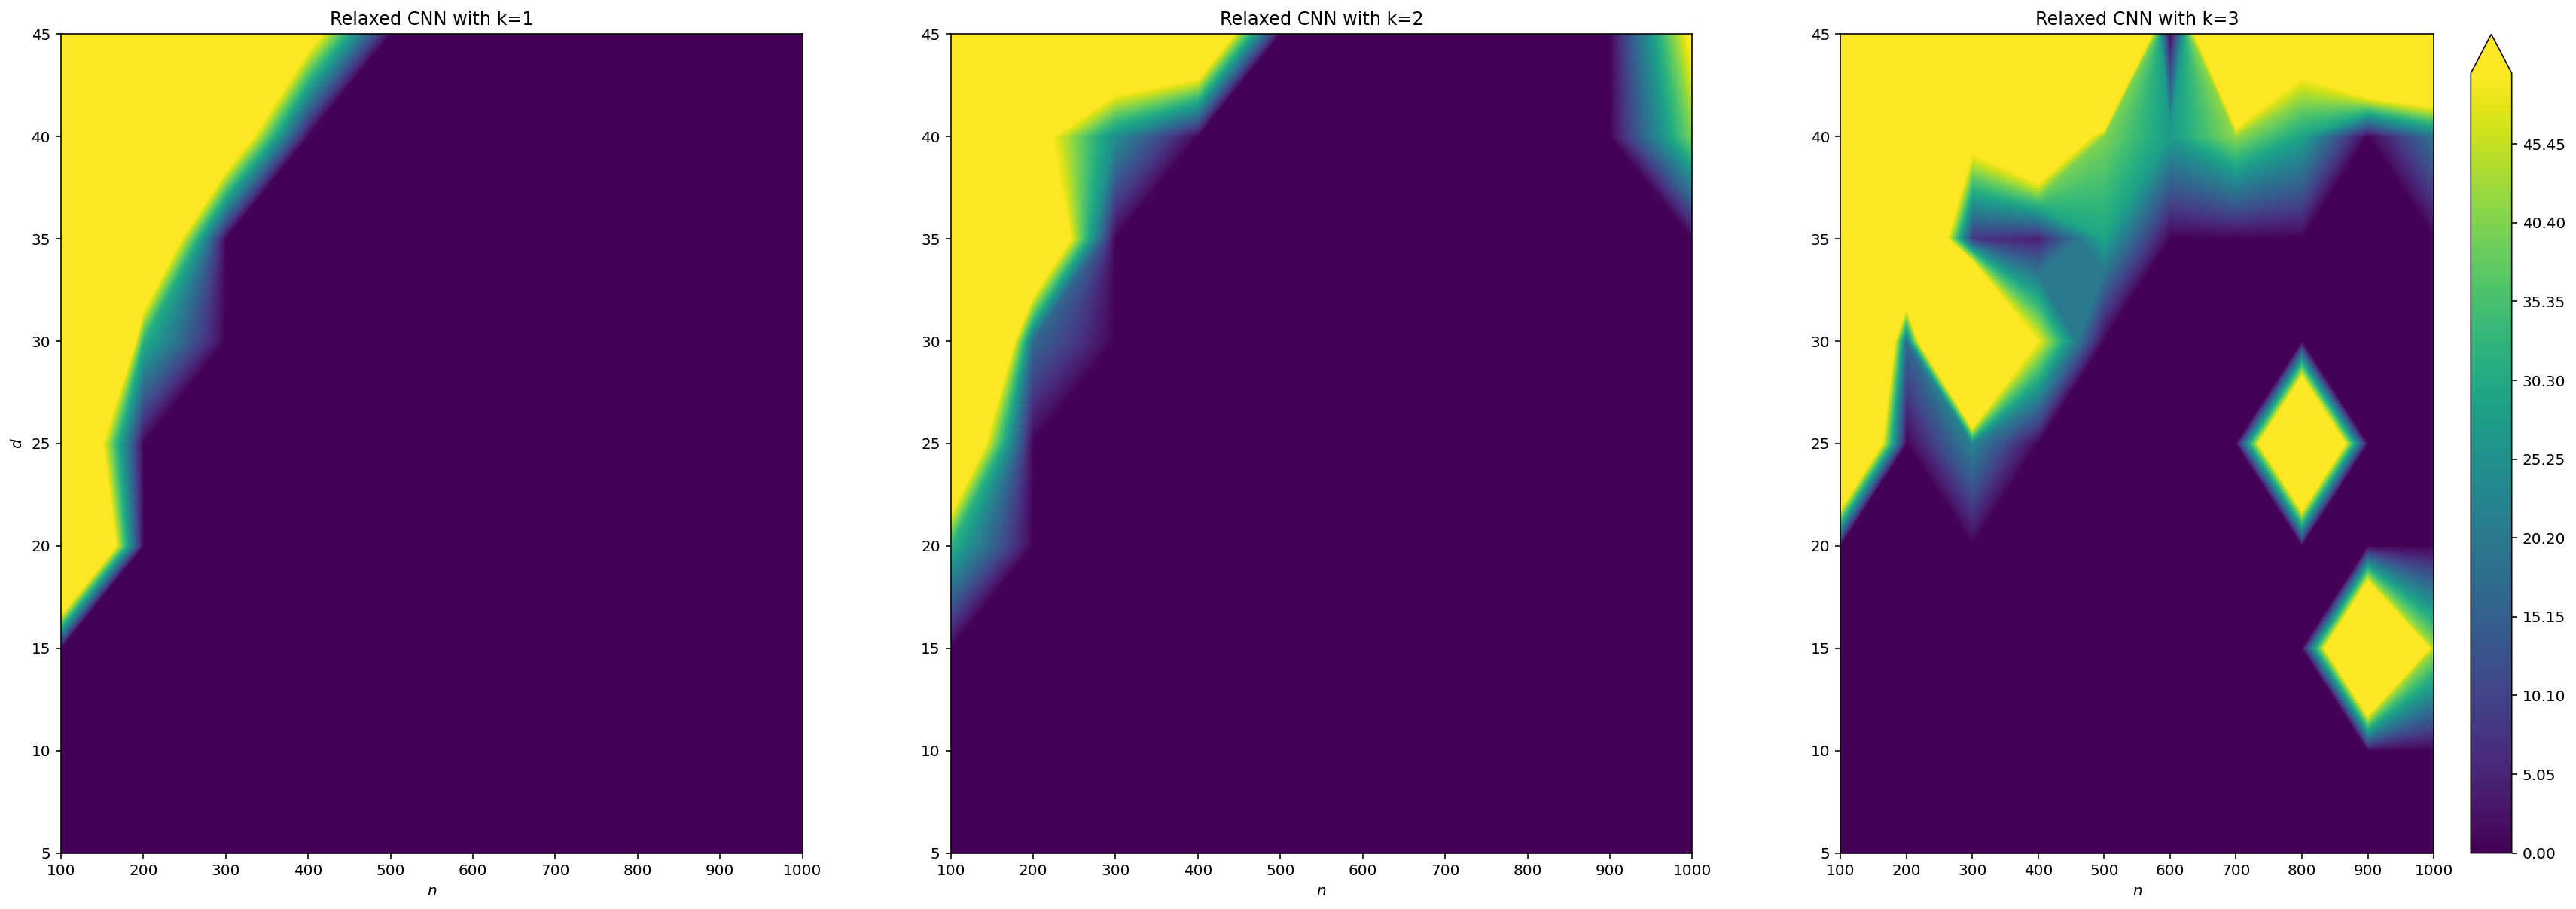

In [22]:
fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(np.array(res_cnn[0]['n']).reshape(len(np.unique(res_cnn[0]['n'])),len(np.unique(res_cnn[0]['d']))),
            np.array(res_cnn[0]['d']).reshape(len(np.unique(res_cnn[0]['n'])),len(np.unique(res_cnn[0]['d']))),
            np.array(res_cnn[0]["100*min_error"]).reshape(len(np.unique(res_cnn[0]['n'])),len(np.unique(res_cnn[0]['d']))), extend='max',
           #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100))
ax1.set_title("Relaxed CNN with k="+str(1))
ax1.set_xlabel("$n$")
ax1.set_ylabel("$d$")

a2=ax2.contourf(np.array(res_cnn[1]['n']).reshape(len(np.unique(res_cnn[1]['n'])),len(np.unique(res_cnn[1]['d']))),
            np.array(res_cnn[1]['d']).reshape(len(np.unique(res_cnn[1]['n'])),len(np.unique(res_cnn[1]['d']))),
            np.array(res_cnn[1]["100*min_error"]).reshape(len(np.unique(res_cnn[1]['n'])),len(np.unique(res_cnn[1]['d']))), extend='max',
            #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100)
              )
ax2.set_title("Relaxed CNN with k="+str(2))
ax2.set_xlabel("$n$")


a3=ax3.contourf(np.array(res_cnn[2]['n']).reshape(len(np.unique(res_cnn[2]['n'])),len(np.unique(res_cnn[2]['d']))),
            np.array(res_cnn[2]['d']).reshape(len(np.unique(res_cnn[2]['n'])),len(np.unique(res_cnn[2]['d']))),
            np.array(res_cnn[2]["100*min_error"]).reshape(len(np.unique(res_cnn[2]['n'])),len(np.unique(res_cnn[2]['d']))), extend='max',
            #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100)
              )
ax3.set_title("Relaxed CNN with k="+str(3))
ax3.set_xlabel("$n$")


plt.colorbar(a3)

The case $k=1$ is similar to the One Node Relu randomly relaxed version. When $k$ increases, the retrieved solution gets unexpectedly far from the good solution as $d$ gets larger, with some unexpected phase transition at $n=800,900$ (as opposed to what is mentionned in the paper). In fact the solver fails many times when $k$ is large.

In [23]:
res_cnn[2]["100*proba"][:5] # 5 estimated 100*probability of success for k=3

[3.0, 1.0101010101010102, 0.0, 0.0, 0.0]

Apart from failures which occur generally in high dimension ($n$ large or $d$ large), the solver takes relatively too much time to find a solution. For instance it took roughly 1 hour to solve all CNN relaxed problems when $k=1$ with the following architecture

In [16]:
! lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          4
On-line CPU(s) list:             0-3
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) CPU @ 2.80GHz
Stepping:                        7
CPU MHz:                         2800.200
BogoMIPS:                        5600.40
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       64 KiB
L1i cache:                       64 KiB
L2 cache:                        2 MiB
L3 cache:                        33 MiB
NUMA node0 CPU(s):               0-3
Vulnerability It

### Gradient descent


The goal is to solve directly the problem:

\begin{align}
\min_{w \in \mathbb{R}^d} \frac{1}{2} \sum_{i=1}^n \bigg( y_i - \sum_{j=1}^k \max\big(0, X_{i,j}w^{(j)}\big) \bigg)^2 = \min_{w \in \mathbb{R}^d}\frac{1}{2}\bigg| \bigg| Y - \sigma_k(X,w) \bigg| \bigg|^2_2
\end{align}

using gradient descent.

The gradient, with respect to $w$, of the objective function can be written, when it exists, as:

\begin{align}
\sum_{j=1}^k -\underbrace{\bigg( \tilde{X}_{i,j} \textbf{1}\big(\tilde{X}_{i,j}w > 0\big)\bigg)^{T}_{1\leq i \leq n}}_{ \in \mathbb{R}^{d\times n}} \underbrace{(Y- \sigma_k(X,w))}_{\in \mathbb{R}^n}
\end{align}

or more generally a subgradient (with $\epsilon \in [0, 1]$) at $w$

\begin{align}
\sum_{j=1}^k -\underbrace{\bigg( \tilde{X}_{i,j} \textbf{1}\big(\tilde{X}_{i,j}w > 0\big) + \epsilon \tilde{X}_{i,j} \textbf{1}\big(\tilde{X}_{i,j}w =0\big) \bigg)^{T}_{1\leq i \leq n}}_{ \in \mathbb{R}^{d\times n}} \underbrace{(Y- \sigma_k(X,w))}_{\in \mathbb{R}^n}
\end{align}

where $\tilde{X}_{i,j}\in \mathbb{R}^{1\times d}$ is such that  $X_{i,j}w^{(j)} = \tilde{X}_{i,j}w$ ($\tilde{X}_{i,j}$ is constructed from $X_{i,j}$ by putting zeros to the other blocks of features) and $\textbf{1}$ is the indicator function, $\sigma_k(X,w) = \sum_{j=1}^k 
\begin{pmatrix} 
\max\big(0, X_{1,j}w^{(j)}\big)\\ 
. \\
. \\
. \\ 
\max\big(0, X_{n,j}w^{(j)}\big)
\end{pmatrix} \in \mathbb{R}
^{n}$ 

In [3]:
def run_gradient_descent(n_s, d_s,k,eps=1e-6, tol=1e-1, eta=0.05, max_iter=1000, N=100):

  results = {"beta": [], "eps":[], "N": [], 
            "n": [], "d":[], "100*proba": [], "100*min_error": []}
  l_n_s = len(n_s)
  l_d_s = len(d_s)
  cart_prod=itertools.product(*[n_s, d_s])
    
  for n,d in tqdm(cart_prod, total=l_n_s*l_d_s):
    mean = [0]*d # mean of a multivariate gaussian
    cov = np.eye(d) # covariance matrix of a multivariate gaussian

    w_star = np.random.randn(d)  # should be the solution found by the solver
    X = np.random.multivariate_normal(mean, cov, n)
    
    X_sliced = np.zeros((n,k*d))
    for j in range(1,k+1):
        start = d*(j-1)
        X_sliced[:, start+(j-1)*(d//k):start + j*(d//k) + (j==k)*(d%k)] =  X[:, (j-1)*(d//k): j*(d//k) + (j==k)*(d%k)]
    
    Y = np.sum(np.maximum(np.concatenate([(X_sliced[:, d*(j-1):d*j]@w_star).reshape(-1,1) for j in range(1,k+1)], axis=1), 0), axis=1)       

    nb_found_sol=0
    nb_errors=0
    error=[]
    for _ in range(N):
        w = np.random.uniform(-1,1, d)
        try:
            for _ in range(max_iter):
                products=np.concatenate([(X_sliced[:, d*(j-1):d*j]@w).reshape(-1,1) for j in range(1,k+1)], axis=1)
                sigma_k = np.sum(np.maximum(products, 0), axis=1)
                s = 0
                for j in range(1,k+1):
                    s = s + np.multiply(X_sliced[:, d*(j-1):d*j], (1*(X_sliced[:, d*(j-1):d*j]@w>0) + tol*(abs(X_sliced[:, d*(j-1):d*j]@w)<1e-6)).reshape(-1,1)) # taking a subgradient at zero with the tolerance parameter
                grad = -s.T @ (Y - sigma_k)
                w = w - eta * grad /np.linalg.norm(grad, ord=2)
            norm1=np.linalg.norm(w - w_star, ord=1)
            norm2=np.linalg.norm(w - w_star, ord=2)
            error.append(norm2)
            if norm1<eps or norm2<eps : nb_found_sol+=1
        except: nb_errors+=1

    if N-nb_errors>0:
        results["100*proba"].append(100*nb_found_sol/(N-nb_errors))
        results["n"].append(n)
        results["d"].append(d)
        results["N"].append(N)
        results["eps"].append(eps)    
        results["100*min_error"].append(100*min(error))
  return results

In [11]:
### Illustrating phase transition for the CNN randomized relaxation problem

min_n = 100
max_n = 1001
min_d = 5
max_d = 201
step_d = 20
step_n = 100

k_s=[1,2,3]

save=True

ax_n = np.arange(min_n, max_n, step_n)
ax_d = np.arange(min_d, max_d, step_d)

for k in k_s:
    print("k=", k)
    if not os.path.isfile('./cnn_gradient_descent_k_'+'equal'+str(k)+ '.pickle'):
        res_grad = run_gradient_descent(ax_n, ax_d, k=k, eps=1e-4, N=10)
        if save: 
            with open('./cnn_gradient_descent_k_'+'equal'+str(k)+ '.pickle', 'wb') as outp:
                pickle.dump(res_grad, outp, pickle.HIGHEST_PROTOCOL)

k= 1


100%|██████████| 100/100 [22:03<00:00, 13.23s/it]


k= 2


100%|██████████| 100/100 [48:26<00:00, 29.06s/it]


k= 3


100%|██████████| 100/100 [44:18<00:00, 26.59s/it]


In [91]:
res_grad=[]
for k in range(1,4):
    res_grad.append(pickle.load(open('./cnn_gradient_descent_k_'+'equal'+str(k)+ '.pickle', 'rb')))


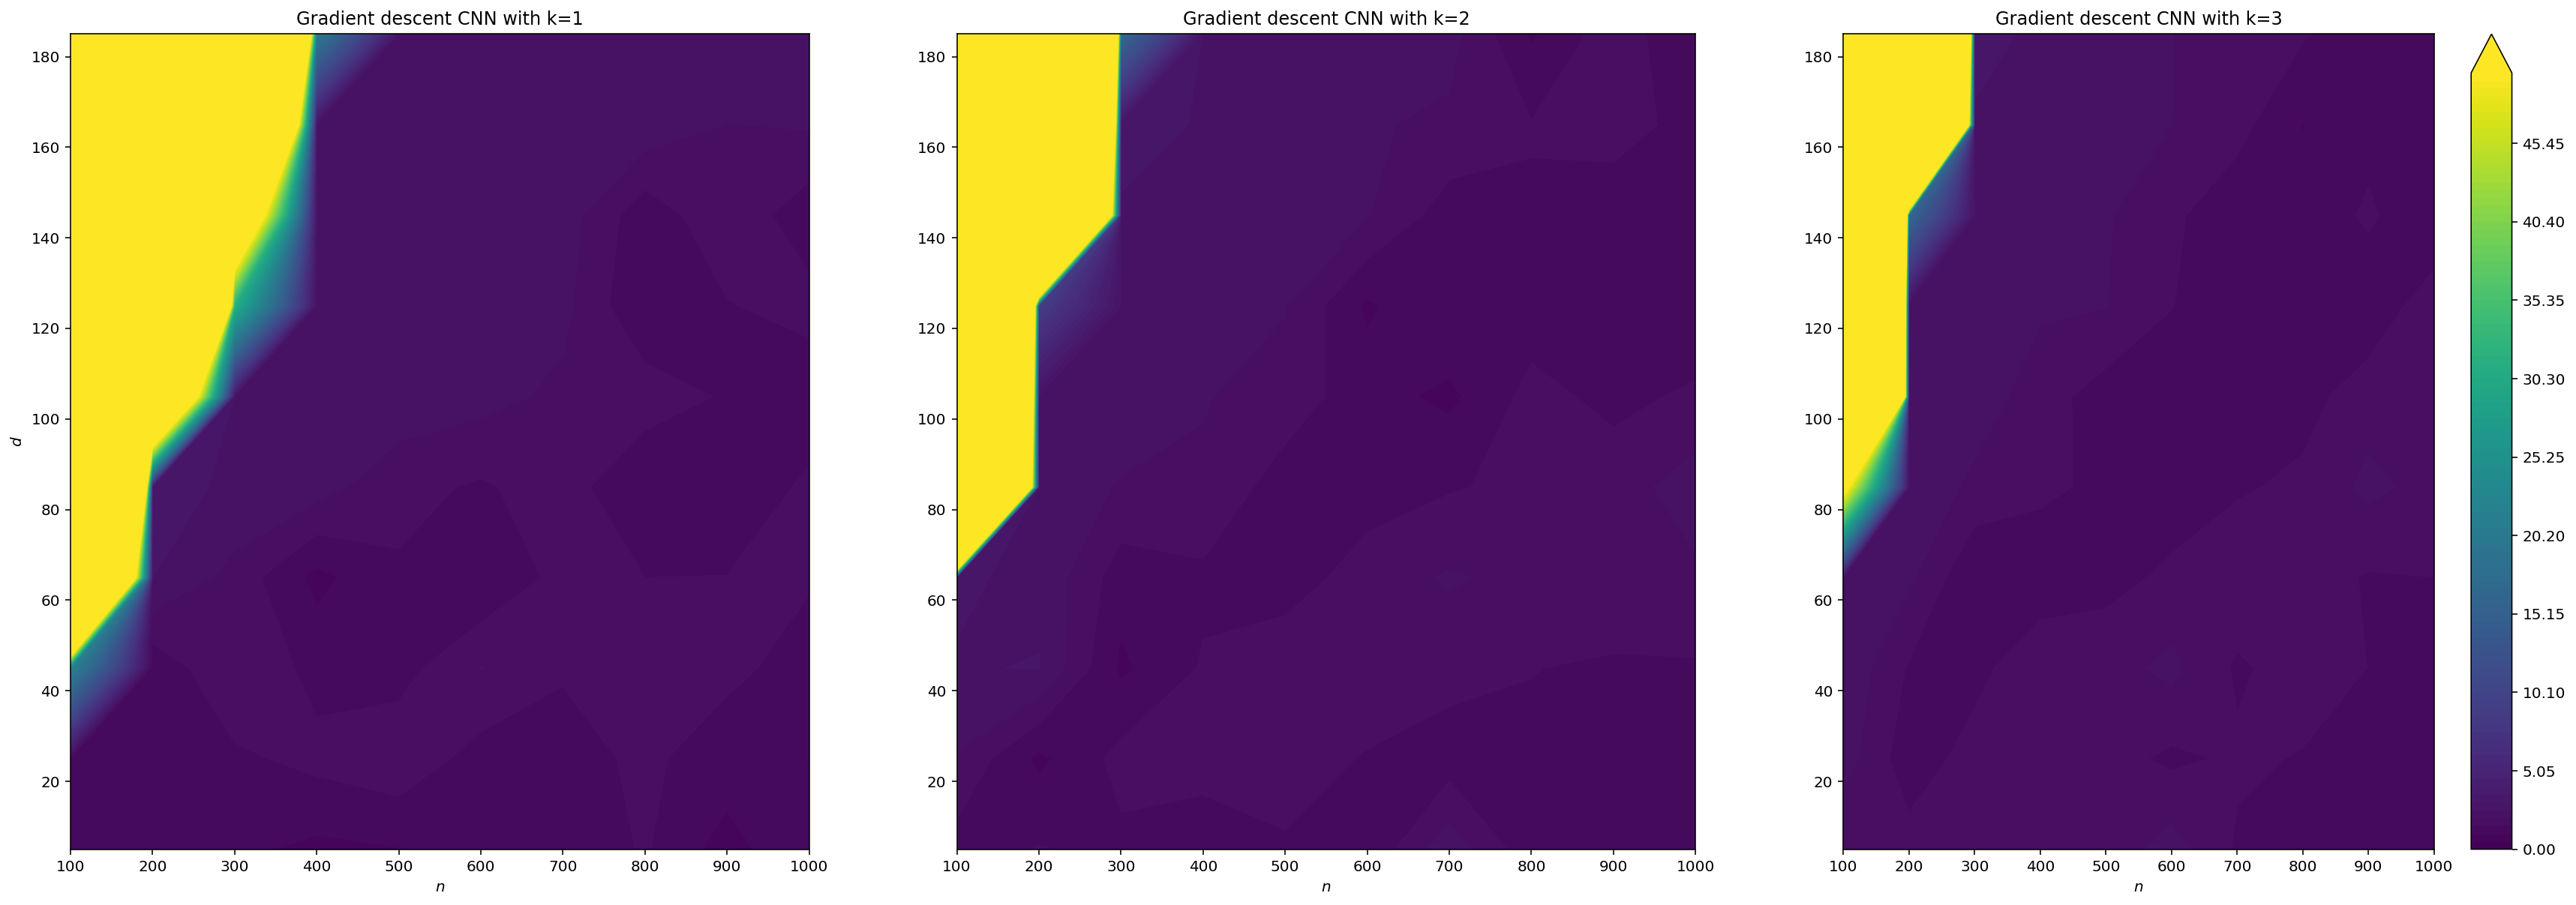

In [92]:
fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.contourf(np.array(res_grad[0]['n']).reshape(len(np.unique(res_grad[0]['n'])),len(np.unique(res_grad[0]['d']))),
            np.array(res_grad[0]['d']).reshape(len(np.unique(res_grad[0]['n'])),len(np.unique(res_grad[0]['d']))),
            np.array(res_grad[0]["100*min_error"]).reshape(len(np.unique(res_grad[0]['n'])),len(np.unique(res_grad[0]['d']))), extend='max',
           #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100))
ax1.set_title("Gradient descent CNN with k="+str(1))
ax1.set_xlabel("$n$")
ax1.set_ylabel("$d$")

a2=ax2.contourf(np.array(res_grad[1]['n']).reshape(len(np.unique(res_grad[1]['n'])),len(np.unique(res_grad[1]['d']))),
            np.array(res_grad[1]['d']).reshape(len(np.unique(res_grad[1]['n'])),len(np.unique(res_grad[1]['d']))),
            np.array(res_grad[1]["100*min_error"]).reshape(len(np.unique(res_grad[1]['n'])),len(np.unique(res_grad[1]['d']))), extend='max',
            #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100)
              )
ax2.set_title("Gradient descent CNN with k="+str(2))
ax2.set_xlabel("$n$")


a3=ax3.contourf(np.array(res_grad[2]['n']).reshape(len(np.unique(res_grad[2]['n'])),len(np.unique(res_grad[2]['d']))),
            np.array(res_grad[2]['d']).reshape(len(np.unique(res_grad[2]['n'])),len(np.unique(res_grad[2]['d']))),
            np.array(res_grad[2]["100*min_error"]).reshape(len(np.unique(res_grad[2]['n'])),len(np.unique(res_grad[2]['d']))), extend='max',
            #vmin=0, vmax=1000,
            levels=np.linspace(0,50,100)
              )
ax3.set_title("Gradient descent CNN with k="+str(3))
ax3.set_xlabel("$n$")


plt.colorbar(a3)

Gradient descent method seems to behave better than the CNN randomly relaxed problem. In fact when $k$ gets large, the solution found by gradient descent gets closer to the true solution, when the number of data $n$ is large enough. One can also notice that gradient descent is much faster (roughly 2.5 times faster for $k=1$)

### MNIST dataset experiments

In [25]:
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [26]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [27]:
x,y = mnist_train[0]  # taking one instance x and its label y
x.size(), y  

(torch.Size([1, 28, 28]), 5)

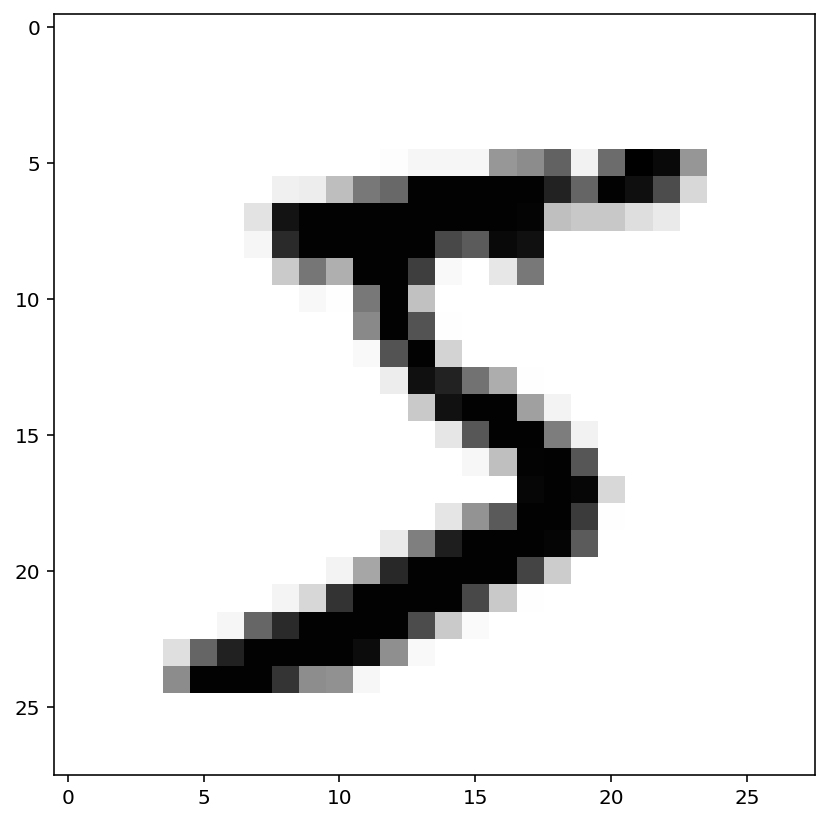

In [28]:
# Let us plot the instance
plt.imshow(x.view(28,28), cmap='Greys')

In [29]:
def rotate_MNIST(data, rotation_angle):
    result = [0]*len(data)

    tensor = transforms.ToTensor()

    for i in tqdm(range(len(data))):
        x,y=data[i]
        img = Image.fromarray(x.view(28,28).numpy())
        result[i] = tensor(img.rotate(rotation_angle[i])).view(28,28)
    return result

rotation angle= 45


100%|██████████| 1/1 [00:00<00:00, 1340.03it/s]


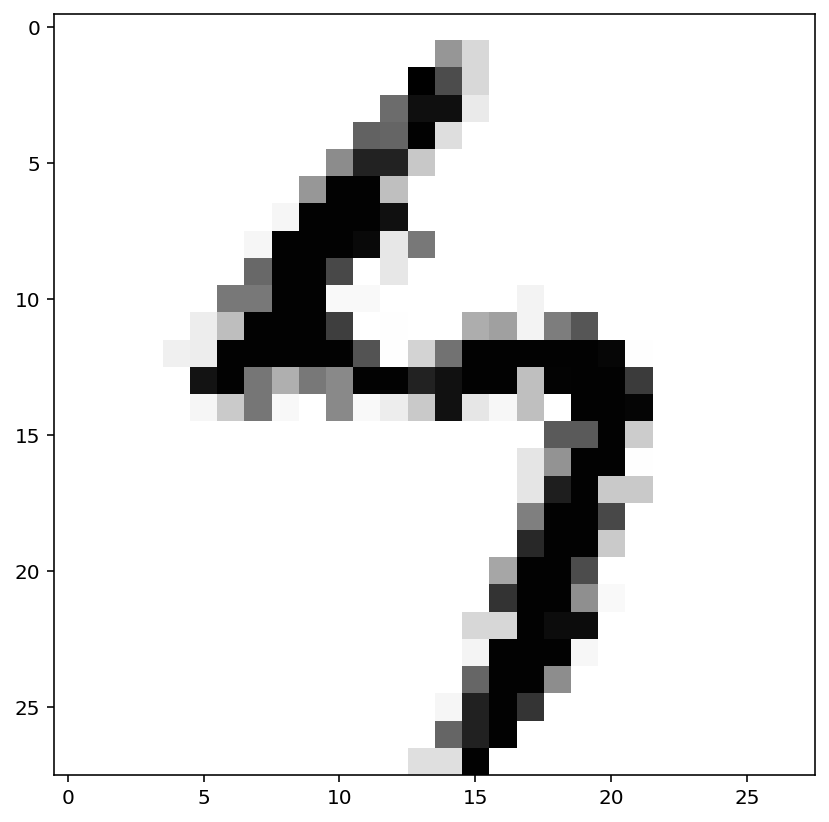

In [30]:
angle=45 
print("rotation angle=", angle)
for x in rotate_MNIST([mnist_train[0]], [angle]): plt.imshow(x, origin="upper", cmap="Greys")

This digit is the number 5, but when rotated, its looks like digit 4, so it is important to be able to  know how much rotated the image is to avoid digits misclassification.

In [68]:
np.random.seed(123)
angles = np.random.uniform(size=len(mnist_train))*45 # rotation between 0 and 45 degrees
rotated_mnist_train = rotate_MNIST([mnist_train[i] for i in range(len(mnist_train))], angles)

100%|██████████| 60000/60000 [00:05<00:00, 10030.84it/s]


In [70]:
X, Y=np.array([rotated_mnist_train[i].view(784).numpy() for i in range(len(rotated_mnist_train))]), angles

In [71]:
X.shape, Y.shape

((60000, 784), (60000,))

#### Training the randomly relaxed penalized CNN on the MNIST training set

In [72]:
beta=1e-5
k=2
lamb=1 # penalty coefficient
n,d =X.shape

X_sliced = np.zeros((n,k*d)) 
for j in range(1,k+1):
    start = d*(j-1)
    X_sliced[:, start+(j-1)*(d//k):start + j*(d//k) + (j==k)*(d%k)] =  X[:, (j-1)*(d//k): j*(d//k) + (j==k)*(d%k)]

r = np.random.randn(d)
w = cp.Variable(d)
Z = cp.Variable(shape=(n, k), nonneg=True) 
ones = np.ones(k) 

cost = sum([0.5*cp.sum_squares(Z @ ones - Y), beta * r @ w, lamb*cp.norm(w,2)]) # we add an l2-penalty
constraints = [-Z@np.array([1*(s==j) for s in range(1,k+1)]) <= -X_sliced[:, d*(j-1):d*j]@w for j in range(1,k+1)]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver="ECOS", verbose=True) # OSQP does not work, we choose ECOS instead

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Mar 23 08:57:16 PM: Your problem has 120784 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 23 08:57:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 23 08:57:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 23 08:57:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 23 08:57:16 PM: Compiling problem (target solver=ECOS).
(CVXPY) Mar 23 08:57:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

1.254877637181153e-06

In [75]:
np.linalg.norm(w.value, ord=2)

1.2482200806207311e-06

#### Testing the result

In [85]:
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
angles_test = np.random.uniform(size=len(mnist_test))*45
rotated_mnist_test = rotate_MNIST([mnist_test[i] for i in range(len(mnist_test))], angles_test)

100%|██████████| 10000/10000 [00:01<00:00, 9104.51it/s]


In [86]:
X_test, Y_test=np.array([rotated_mnist_test[i].view(784).numpy() for i in range(len(rotated_mnist_test))]), angles_test

In [87]:
X_test_sliced = np.zeros((X_test.shape[0],k*X_test.shape[1]))

for j in range(1,k+1):
    start = d*(j-1)
    X_test_sliced[:, start+(j-1)*(d//k):start + j*(d//k) + (j==k)*(d%k)] = X_test[:, (j-1)*(d//k): j*(d//k) + (j==k)*(d%k)]

Y_pred = np.sum(np.maximum(np.concatenate([(X_test_sliced[:, d*(j-1):d*j]@w.value).reshape(-1,1) for j in range(1,k+1)], axis=1), 0), axis=1)

In [88]:
print("average rotation angle on the test set {}°".format(np.mean(angles_test)))

average rotation angle on the test set 22.344798165581242°


In [89]:
print("root mean squared error = {}°".format(np.sqrt(np.mean((Y_test - Y_pred)**2))))

root mean squared error = 25.86384531501009°


The relaxed model does not seem to behave well on the MNIST dataset, in fact, the root mean squared error on the test set is above the average of the rotation angles of the test set images. 

### Conclusion

The naive relaxation of the One node ReLU problem or more generally of the CNN with non-overlapping filters has trouble finding the solution under the teacher network hypothesis (i.e when the labels $Y$ are generated by a version of the network, or equivalently when the initial problem objective function's optimal value is 0). However, by introducing a random perturbation in the problem, one increases the probability to retrieve the true solution as long as the data size is large enough. In practice, the solvers may fail or take too long to solve the problem in a big data framework.

## Paper 2: A Convex Relaxation Barrier to Tight Robustness Verification of Neural Networks$^{[2]}$

### Overview

In this article, the authors address the problem of Robustness Verification of Neural Networks. This problem aims to study the sensitivity of a neural network's output with respect to a small perturbation of the input. Multiple formulations and methods exist to assess the robustness of a neural network. In this setting, we formulate the problem as follows:

Let $f: \mathbb{R}^n \to \mathbb{R}^k $ be a neural network and $x \in \mathbb{R}^n$ an input. Denote $(f_i(x))_{i \in \{1..k\}}$ the classification scores obtained by the output layer for each class. $f$ is said to be adversarially robust w.r.t. $x$ and perturbation $\varepsilon$ if $\forall \delta \in B_\infty(0,\varepsilon), f(x+\delta) = f(x)$, or equivalently:

\begin{equation} \min _{x^{\prime} \in B_\infty(x,\varepsilon), i \neq i^{*}} f_{i^{*}}(x)-f_{i}\left(x^{\prime}\right)>0, \quad \text { where } \quad i^{*}=\underset{j}{\arg \max } f_{j}(x) .\quad \quad \quad (\mathcal{A}) \end{equation}

Robustness verification consists in evaluating whether the preceding property holds for given $\varepsilon$ and input(s). To prove that it holds, it is sufficient to provide a positive lower bound on ($\mathcal{A}$), and this can be done more efficiently using convex relaxations of the associated optimization problem. Conversely, to prove that it doesn't hold, it is sufficient to provide a counter-example, i.e. an adversary input $x' \in B_\infty(x,\varepsilon)$ and target class $j \ne i^*$ s.t. $f_j(x') > f_{i^{*}}(x')$. Those two problems have received wide attention from researchers in the recent years since the introduction of Deep Learning into sensitive applications (medicine, autonomous vehicles, etc.) where the robustness, i.e. stability of the model's output w.r.t. the input is critical. As such, many methods have been proposed to solve those two problems efficiently and close the gap between the two bounds on $\varepsilon_{\max}$ that they imply (where $\varepsilon_{\max}(x) = \max \{\varepsilon, f$ robust w.r.t. $x$ and $\varepsilon \}$).

In this article, the authors study and unify recent state-of-the-art works on relaxed neural network verification within a single framework, provide an algorithm to find the exact solution of the relaxed problem, and perform large-scale experiments to compare the exact solution (computationally expensive) with the approximate solutions provided by state-of-the-art approximate solvers.


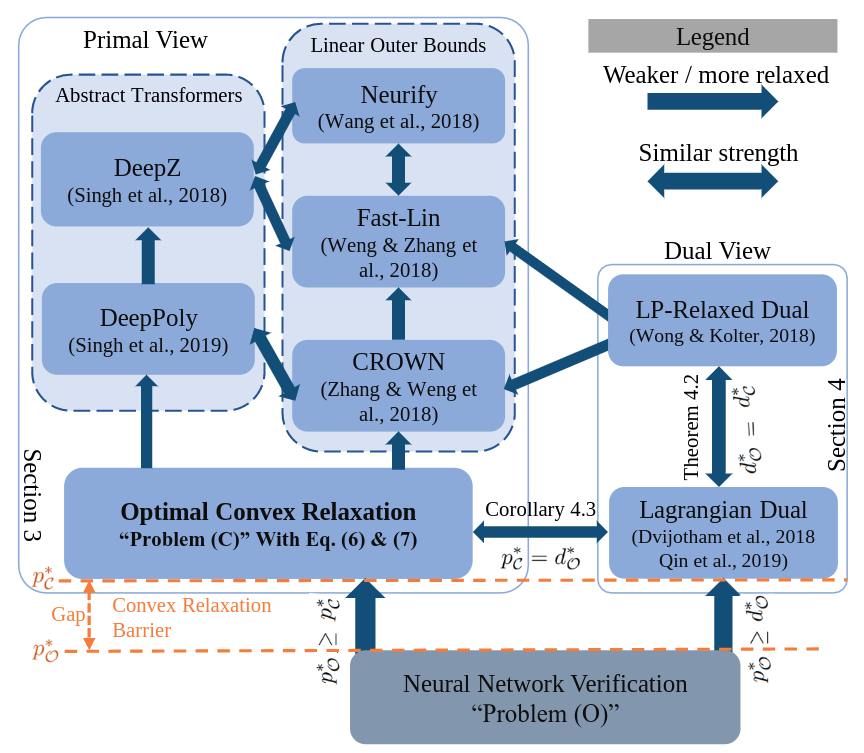

#### Original problem
Let $x^{nom} \in \mathbb{R}^{n^{(0)}}$ an input, $\mathcal{S}_{i n}\left(x^{nom}\right)$ a convex neighbourhood of $x$ (usually $\mathcal{S}_{i n}\left(x^{nom}\right) = B_\infty(x^{nom},\varepsilon)$), and $f$ an $L$-layer neural network defined by:

$x^{(l+1)}=\sigma^{(l)}\left(\mathbf{W}^{(l)} x^{(l)}+b^{(l)}\right) \quad \forall l \in[L], \quad$ where $[L]$ denotes the set $\{0,1,..,L-1\}$, $x^{(l)} \in \mathbb{R}^{n^{(l)}}, z^{(l)} \in \mathbb{R}^{n_{z}^{(l)}}, \quad \mathbf{W}^{(l)} \in \mathbb{R}^{n_{z}^{(l)} \times n^{(l)}}, \; b^{(l)} \in \mathbb{R}^{n_{z}^{(l)}}, \; x^{(0)}:=x$ is the input and $f(x):=z^{(L)}=\mathbf{W}^{(L)} x^{(L)}+b^{(L)}$ is the output. $\sigma^{(l)}: \mathbb{R}^{n_{z}^{(l)}} \rightarrow \mathbb{R}^{n^{(l+1)}}$ denotes a non-linear activation function (e.g. ReLU, MaxPool, etc.). The authors define the Neural Network Verification Problem ($\mathcal{O}$) as follows:
\begin{aligned}
\min _{\left(x^{[L+1]}, z^{[L]}\right) \in \mathcal{D}} & c^{\top} x^{(L)}+c_{0} \\
\text { s.t. } & z^{(l)}=\mathbf{W}^{(l)} x^{(l)}+b^{(l)}, l \in[L] \quad \quad \quad \quad \quad (\mathcal{O})\\
& x^{(l+1)}=\sigma^{(l)}\left(z^{(l)}\right), l \in[L]
\end{aligned}
where $\mathcal{D}=\left\{\left(x^{[L+1]}, z^{[L]}\right): x^{(0)} \in \mathcal{S}_{i n}\left(x^{\mathrm{nom}}\right), \quad \underline{z}^{(l)} \leq z^{(l)} \leq \bar{z}^{(l)}, l \in[L]\right\}$.

The specified constraints indicate that $x^{[L]}$ is the pre-output of the neural network $f$ (the output is a linear function of $x^{[L]}$: $f(x^{(0)}) = \mathbf{W}^{(L)} x^{(L)}+b^{(L)}$). $\underline{z}^{(l)}$ and $\bar{z}^{(l)}$ allow us to specify bounds on the preactivations, and for $c^{\top}=\mathbf{W}_{i^{\text {nom }},:}^{(L)}-\mathbf{W}_{i,:}^{(L)}, c_{0}=b_{i^{\text {nom }}}^{(L)}-b_{i}^{(L)}, \underline{z}^{[L]}=-\infty, \text { and } \bar{z}^{[L]}=\infty$, problem ($\mathcal{O}$) is equivalent to problem ($\mathcal{A}$).

However, this problem is NP-Complete[3], mainly because its feasible set in not convex. Therefore researchers have been developing convex relaxations of the problem to make it tractable.


#### Relaxed problems

##### Primal View
One common convex relaxation of the feasible set is to replace the equality constraints $x^{(l+1)}=\sigma^{(l)}\left(z^{(l)}\right)$ by the inequalities $ \underline{\sigma}^{(l)}\left(z^{(l)}\right) \leq x^{(l+1)} \leq \bar{\sigma}^{(l)}\left(z^{(l)}\right)$ where $\underline{\sigma}^{(l)}$ and $\bar{\sigma}^{(l)}$ are respectively convex and concave functions that provide lower and upper bounds on $\sigma^{(l)}$ (problem $\mathcal{C}$). By taking $\underline{\sigma}^{(l)}$ and $\bar{\sigma}^{(l)}$ to be affine functions, we obtain linear bounds on $x^{(L)}$ (as a linear combination of linear bounds) which allows for efficient solving of this convex problem.

This technique is used in several verifiers such as Fast-Lin [4], DeepZ [5], Neurify [6], CROWN [7] and DeepPoly [8].

##### Dual View
We can write the Lagrangian of the relaxed problem ($\mathcal{C}$) as:
\begin{aligned}
g_{\mathcal{C}}\left(\mu^{[L]}, \underline{\lambda}^{[L]}, \bar{\lambda}^{[L]}\right):=& \min _{\left(x^{[L+1]}, z^{[L]}\right) \in \mathcal{D}} c^{\top} x^{(L)}+c_{0}+\sum_{l=0}^{L-1} \mu^{(l) \top}\left(z^{(l)}-\mathbf{W}^{(l)} x^{(l)}-b^{(l)}\right) \\
&-\sum_{l=0}^{L-1} \underline{\lambda}^{(l) \top}\left(x^{(l+1)}-\underline{\sigma}^{(l)}\left(z^{(l)}\right)\right)+\sum_{l=0}^{L-1} \bar{\lambda}^{(l) \top}\left(x^{(l+1)}-\bar{\sigma}^{(l)}\left(z^{(l)}\right)\right)
\end{aligned}

Then by weak duality: $d_{\mathcal{C}}^{*}:=\max _{\mu^{[L]}, \underline{\lambda}^{[L]} \geq 0, \bar{\lambda}^{[L]} \geq 0} g_{\mathcal{C}}\left(\mu^{[L]}, \underline{\lambda}^{[L]}, \bar{\lambda}^{[L]}\right) \leq p_{\mathcal{C}}^{*} \quad \quad \quad \quad (\mathcal{D})$

which allows us to lower bound $p_{\mathcal{C}}^{*}$.

Furthermore, the authors prove that if $\underline{\sigma}^{(l)}$ and $\bar{\sigma}^{(l)}$ have a finite Lipschitz constant in [z(l),z(l)] $\forall l \in[L]$, Then strong duality holds with the primal relaxation ($\mathcal{C}$).

The authors also prove that under mild conditions (def. B.2, which holds for most common activation functions), solving the dual of the original problem ($\mathcal{O}$) is equivalent to solving ($\mathcal{C}$) and therefore provides no improvement over the lower bounds yielded by ($\mathcal{C}$) or ($\mathcal{D}$). This suggests the existence of a *barrier* that prevents us from obtaining optimal solutions whether we solve problem ($\mathcal{C}$), ($\mathcal{D}$), or the dual of ($\mathcal{O}$).

As in the primal view, the authors choose the relaxed bounds $\underline{\sigma}$ and $\bar{\sigma}$ to be linear, which allows them to propose a greedy algorithm to solve the relaxed dual problem. This formulation and consequent algorithm provide a generalisation of the works of Wong and Kolter [9], Fast-Lin [4] and CROWN [10] which can be seen as special cases.

### Paper's experiments

The authors conduct large-scale experiments (amounting to more than 22 CPU-years) to find out whether convex-relaxed verifiers can empirically obtain error bounds that are close to the exact solution of the original problem ($\mathcal{O}$) or not. To this end, they introduce LP-ALL, the tightest convex relaxation within the previously presented framework ($\underline{\sigma}$ and $\bar{\sigma}$ are resp. the convex hull and concave hull of $\sigma$), and compare its results with an exact verifier (MILP) and the upper bounds provided by an adversarial attack such as PGD. They also compare LP-ALL with LP-GREEDY [9] which is a greedy dual algorithm (faster but yields suboptimal solutions), and LP-LAST which is intermediate in speed and accuracy between them. They perform two main experiments on a variety of neural networks.

#### Experiment 1: Certified upper bounds on the robust error

In this experiment, the authors use 2 NN architectures (MLP-A and MLP-B) with respectively 1 hidden layer/500 neurons, and 2 layers/2$\times$100 neurons. They are trained on the MNIST dataset with three different training modes: $NOR$ (normal), $ADV$ (robust training from [11]) and $LP_D$ (robust training from [9]). For each neural network and different $\varepsilon$ values, the authors compute the test error and upper and lower bounds of the robust error, which are defined as follows:
- Test error (TE): $\frac{\text{Incorrectly classified test samples}}{\text{Number of test samples}}$
- Lower bound on the robust error: For each test sample $x$, run PGD[11] (resp. MILP[12]) algorithm to find adversarial examples within $B_\infty(x, \varepsilon)$. If found, label $x$ as incorrectly classified, otherwise it is correctly classified. The error is then calculated as in (TE).
- Higher bound on the robust error: For each test sample $x$, run MILP (resp. LP-ALL, LP-GREEDY) algorithm to certify the non-existence of adversarial examples within $B_\infty(x, \varepsilon)$. This is done by running the specified algorithm to find a lower bound for problem $(\mathcal{O})$. If this lower bound is positive (which implies the non-existence of adversarial examples within $B_\infty(x, \varepsilon)$), then label $x$ as correctly classified, otherwise label it as incorrectly classified. The error is then calculated as in (TE).

Basically, to calculate the robust error, a sample $x$ is considered correctly classified if all $x' \in B_\infty(x, \varepsilon)$ are correctly classified. The experiment results are presented below:


\begin{array}{lrrrrrrrr}
\hline & & \text{  } & |\text { LOWER BOUND } & & | \text { UPPER BOUND } \\
\text { NETWORK } & \epsilon & \text {TEST ERROR } & \text { PGD } & \text { MILP }  & \text { MILP } & \text { LP-ALL } & \text { LP-GREEDY } \\
\hline \text { ADV-MLP-B } & 0.03 & 1.53 \% & 4.17 \% & 4.18 \% & 5.78 \% & 10.04 \% & 13.40 \% \\
\text { ADV-MLP-B } & 0.05 & 1.62 \% & 6.06 \% & 6.11 \% & 11.38 \% & 23.29 \% & 33.09 \% \\
\text { ADV-MLP-B } & 0.1 & 3.33 \% & 15.86 \% & 16.25 \% & 34.37 \% & 61.59 \% & 71.34 \% \\
\text { ADV-MLP-A } & 0.1 & 4.18 \% & 11.51 \% & 14.36 \% & 30.81 \% & 60.14 \% & 67.50 \% \\
\hline \text { NOR-MLP-B } & 0.02 & 2.05 \% & 10.06 \% & 10.16 \% & 13.48 \% & 26.41 \% & 35.11 \% \\
\text { NOR-MLP-B } & 0.03 & 2.05 \% & 20.37 \% & 20.43 \% & 48.67 \% & 65.70 \% & 75.85 \% \\
\text { NOR-MLP-B } & 0.05 & 2.05 \% & 53.37 \% & 53.37 \% & 94.04 \% & 97.95 \% & 99.39 \% \\
\hline \text { LPD-MLP-B } & 0.1 & 4.09 \% & 13.39 \% & 14.45 \% & 14.45 \% & 17.24 \% & 18.32 \% \\
\text { LPD-MLP-B } & 0.2 & 15.72 \% & 33.85 \% & 36.33 \% & 36.33 \% & 37.50 \% & 41.67 \% \\
\text { LPD-MLP-B } & 0.3 & 39.22 \% & 57.29 \% & 59.85 \% & 59.85 \% & 60.17 \% & 66.85 \% \\
\text { LPD-MLP-B } & 0.4 & 67.97 \% & 81.85 \% & 83.17 \% & 83.17 \% & 83.62 \% & 87.89 \% \\
\hline
\end{array}

Note that the MILP[12] algorithm can both find adversarial examples and certify the robustness of a robust sample (so it can calculate the exact robust error, not only upper and lower bounds). However it is computationally expensive and the authors set a runtime timeout that was reached for $ADV$ and $NOR$-trained NNs, which explains the gap between the MILP upper and lower bounds for these NNs.

The main takeaway from this experiment is that for all normally-trained NNs, and also for $ADV$ NNs, the upper bounds obtained by convex-relaxed verifiers (LP-GREEDY and LP-ALL) are too loose (about twice the actual robust error, in contrast with the tight bounds provided PGD). Even using the optimal convex relaxation (LP-ALL) doesn't significantly improve the bound compared to a commonly-used greedy algorithm. This illustrates the "convex relaxation barrier" after which the paper is titled: Convex relaxation of the NN verification problem inherently prevents tight verification (e.g. obtaining tight bounds for the robust error), and therefore all previous (and eventually future) works on NN verification which fall within the convex relaxation framework presented in this paper are doomed to have relatively poor performance, and finding better convex relaxations of $\sigma$ doesn't really improve their performance.

#### Experiment 2: Certified lower bounds on the minimum adversarial distortion
In the second experiment, the authors compute lower bounds on the minimum adversarial distortion, which is defined as the radius of the largest $l_\infty$ ball in which no adversarial examples can be crafted given an input $x$, i.e. $\varepsilon_x = \max \{\varepsilon \in \mathbb{R}_+, \forall x' \in B_\infty(x,\varepsilon) \; f(x')=f(x)\}$.

PGD is used to find adversarial samples and therefore compute higher bounds on $\varepsilon_x$, while lower bounds are calculated via binary search using LP-GREEDY, LP-LAST, and LP-ALL. This is done for ten samples of the MNIST and CIFAR-10 datasets. Results are reported below:

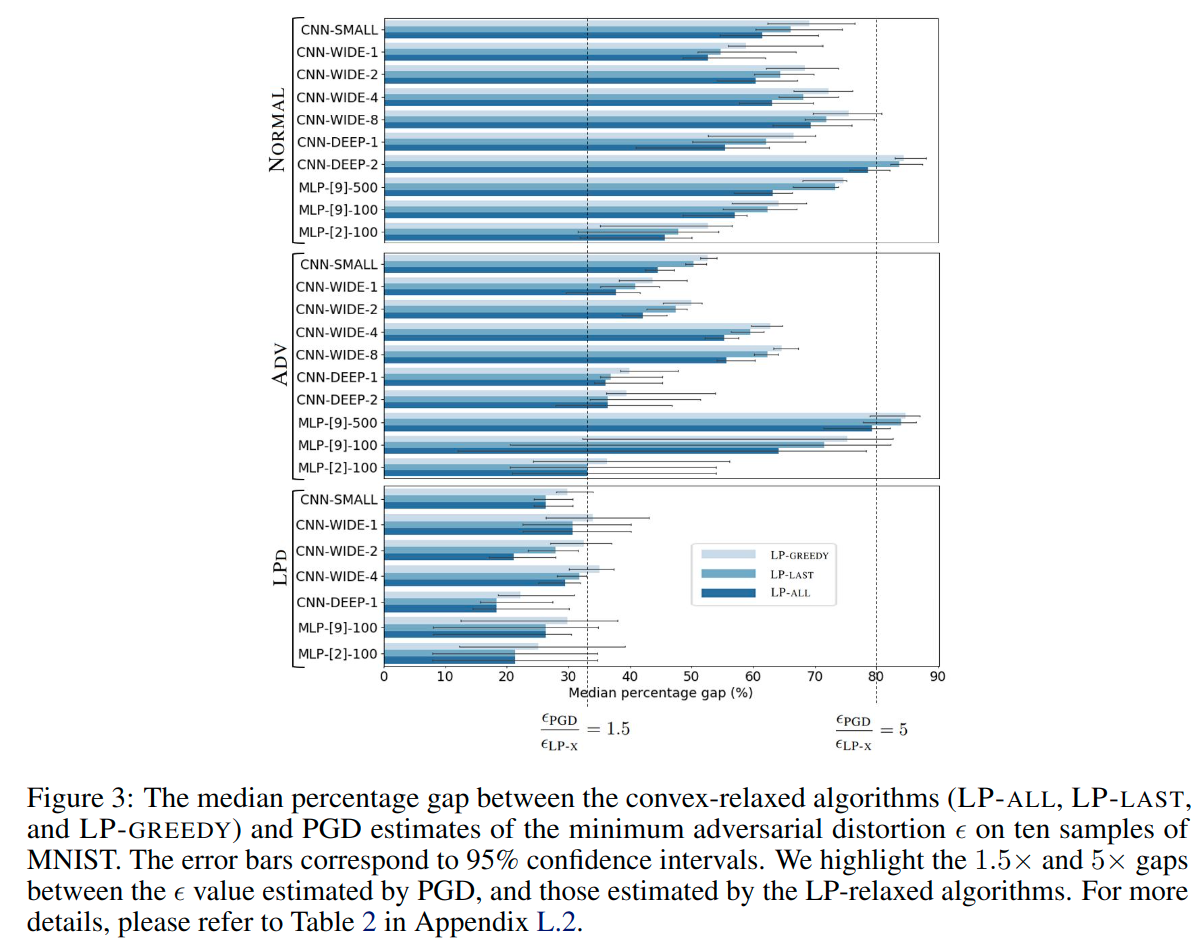

The large gap between the upper bounds found using PGD and the lower bands provided by the convex-relaxed verifiers confirms our conclusions from the previous experiment. Namely, using the optimal convex-relaxed verifier LP-ALL doesn't close the gap between commonly used greedy algorithms like LP-GREEDY and the PGD upper bound; it only slightly improves the lower bound. This highlights the convex relaxation barrier discussed earlier.

### Our experiments

Although the authors provide the source-code of their experiments, due to the large-scale nature of their experiments (totalling 22 CPU-years), we are unable to reproduce their results. However, we can demo a few of the algorithms used to perform the paper's experiments.

First we train a 3-layer neural network to classify MNIST digits:

In [51]:
!git clone https://github.com/Hadisalman/robust-verify-benchmark

Cloning into 'robust-verify-benchmark'...
remote: Enumerating objects: 98, done.
remote: Total 98 (delta 0), reused 0 (delta 0), pack-reused 98
Unpacking objects: 100% (98/98), 80.27 MiB | 13.90 MiB/s, done.
Encountered 1 file that should have been a pointer, but wasn't:
	weights/experiment_1/MIPVerify_data/weights/mnist/RSL18a/linf0.1/two-layer.mat


In [80]:
import os
# to be able to import it, module name must have no hyphens
os.rename("robust-verify-benchmark","rvb")

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time
import numpy as np
from rvb.wong_kolter.version0point2 import Affine, full_bias
from rvb.wong_kolter import DualNetBounds as DualNetBounds
import cvxpy as cp
from joblib import Parallel, delayed

In [2]:
# config
epsilon = 0.025 # radius of the allowed perturbation ball B_\infty(0,epsilon)
torch.manual_seed(42);

In [3]:
n_classes = 10

train_set = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
test_set = datasets.MNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, pin_memory=True)

In [4]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,n_classes)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(25):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    if epoch % 2 == 0:
        print(f'[epoch {epoch + 1}] loss: {running_loss:.1f}')
        running_loss = 0.0

[epoch 1] loss: 1005.3
[epoch 3] loss: 285.5
[epoch 5] loss: 175.0
[epoch 7] loss: 120.1
[epoch 9] loss: 83.6
[epoch 11] loss: 67.6
[epoch 13] loss: 60.0
[epoch 15] loss: 58.4
[epoch 17] loss: 47.1
[epoch 19] loss: 45.6
[epoch 21] loss: 45.6
[epoch 23] loss: 36.1
[epoch 25] loss: 38.7


In [5]:
# save model
torch.save(net, 'mnist_nn.pth')

In [6]:
# load model
net = torch.load('mnist_nn.pth')
net.eval()

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=10, bias=True)
)

In [7]:
# test accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test data: {100 * correct // total} %')

Accuracy on test data: 97 %


In [8]:
test_loader_iter = iter(test_loader)

In [9]:
# pick a sample input to be used for robustness verification
x, y = next(test_loader_iter)
sample = x.flatten().numpy()
y_pred = net(x).max(1)[1]
print(f"Sample prediction: {y_pred.item()}\nGround truth: {y.numpy()[0]}")

Sample prediction: 7
Ground truth: 7


We will test several algorithms to verify whether our neural network is robust around the sample $x$:

LP-GREEDY[9]:

We use the LP-GREEDY algorithm to calculate lower bounds of the margins, which are the minimum differences of score between the correct class and other classes for all inputs in $B_\infty(x, \varepsilon)$, as defined in Eq (7). From here on and unless otherwise specified, we will refer to the lower bounds of the margins as simply "margins".

If all margins are positive, then our neural network is certified to be robust wrt input $x$ and perturbation $\varepsilon$.

CPU time: 0.003 s
Robustness NOT certified for epsilon=0.025 using LP-GREEDY


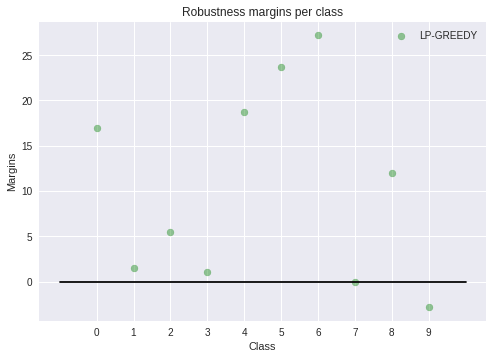

In [17]:
def lp_greedy(net, x, epsilon=epsilon):
    y_pred = net(x).max(1)[1]
    dual_net = DualNetBounds(net, x, epsilon, bounded_input=True)
    C = torch.eye(n_classes).type_as(x)[y_pred].unsqueeze(1) - torch.eye(n_classes).type_as(x).unsqueeze(0)
    margins_lp_greedy = dual_net(C).data
    margins_lp_greedy = margins_lp_greedy.flatten().data.numpy()
    return margins_lp_greedy

times = []
start = time()
margins_lp_greedy = lp_greedy(net, x)
times.append(time() - start)
print(f"CPU time: {times[-1]:.3f} s")
plt.style.use('seaborn')
plt.scatter([i for i in range(n_classes)],margins_lp_greedy, label='LP-GREEDY', color='g', alpha=0.4)
plt.plot([-1,n_classes],[0,0], color='k')
plt.legend()
plt.title('Robustness margins per class')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_greedy)>=0):
    print(f'Robustness certified for epsilon={epsilon} using LP-GREEDY')
else:
    print(f"Robustness NOT certified for epsilon={epsilon} using LP-GREEDY")

In [18]:
def verify(margins):
    return(np.all(np.array(margins)>=0))
verify(lp_greedy(net, x, epsilon)) # return whether a neural network is robust wrt given input and epsilon

False

LP-LAST:

CPU time: 2.107 s
Robustness certified for epsilon=0.025 using LP-LAST


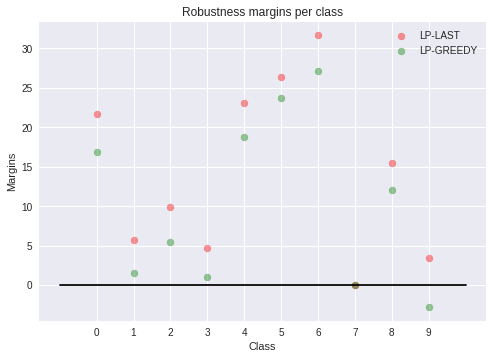

In [19]:
def get_linearLayers_net(W, b):
    layers_list = [[nn.Linear(ww.shape[1],ww.shape[0]), nn.ReLU()] for ww in W]
    flat_layers_list = [item for sublist in layers_list for item in sublist]
    net = nn.Sequential(nn.Flatten(),
                       *flat_layers_list[:-1])
    # Load weights
    i = 0
    for idx,l in enumerate(net):
        if isinstance(l, nn.Linear):
            l.weight.data = torch.Tensor(W[i])
            l.bias.data = torch.Tensor(b[i])
            i += 1
    return net


def init_affine(net, X):
    layers = [l for l in net if isinstance(l, (nn.Linear, nn.Conv2d))]
    affine = [Affine(l) for l in layers]

    _ = X.view(1,-1)
    for a in affine: 
        _ = a(_)

    biases = [full_bias(l, affine[i].out_features) 
                    for i,l in enumerate(layers)]
    return affine, biases

def lp_last(net, x, epsilon=epsilon):
    y_pred = net(x).max(1)[1]
    sample = x.flatten().numpy()
    C = np.eye(n_classes)[y_pred] - np.eye(n_classes)

    affine, biases = init_affine(net, x)
    num_linear_layers = len(affine)

    # Get the weights and biases from the network. Will be used in the LP formulation later
    W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
    b = [bias.view(-1).cpu().data.numpy() for bias in biases]

    # Popoulate the preactivation bounds of all layers except the last layer
    zl = []
    zu = []
    for idx, (ww,bb) in enumerate(zip(W,b), start=1):
        dual_net = DualNetBounds(get_linearLayers_net(W[:idx], b[:idx]), x, epsilon, bounded_input=True)
        CC = torch.eye(ww.shape[0]).type_as(x).unsqueeze(0)
        zl.append(dual_net(CC).data.squeeze(0))
        CC = -torch.eye(ww.shape[0]).type_as(x).unsqueeze(0)
        zu.append(-dual_net(CC).data.squeeze(0))

    # This LP formulation can be found in Appendix A.1 of Wong and Kolter 2018 (https://arxiv.org/abs/1711.00851)
    # The implementation is modified from (https://github.com/locuslab/convex_adversarial)
    z = [cp.Variable(l.in_features) for l in affine]
    zhat = [cp.Variable(l.out_features) for l in affine]

    # Constraints of the LP
    cons_eq = [zhat[i] == W[i]@z[i] + b[i] for i in range(num_linear_layers)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
    cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
    cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                   cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                   zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(num_linear_layers-1)]

    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

    # For each neuron in the last layer, solve an LP to find the margin
    margins_lp_last = []
    for node_idx in range(zu[-1].shape[0]):
        f_primal = cp.Problem(cp.Minimize(C[node_idx]@zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
        margins_lp_last.append(f_primal)
    return(margins_lp_last)

start = time()
margins_lp_last = lp_last(net, x)
times.append(time() - start)
print(f"CPU time: {times[-1]:.3f} s")

plt.scatter([i for i in range(10)],margins_lp_last, label='LP-LAST',color='r', alpha=0.4)
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')

plt.legend()
plt.title('Robustness margins per class')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_last)>=0):
    print('Robustness certified for epsilon={} using LP-LAST'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-LAST'.format(epsilon))

LP-ALL:

CPU time: 42.116 s
Robustness certified for epsilon=0.025 using LP-ALL


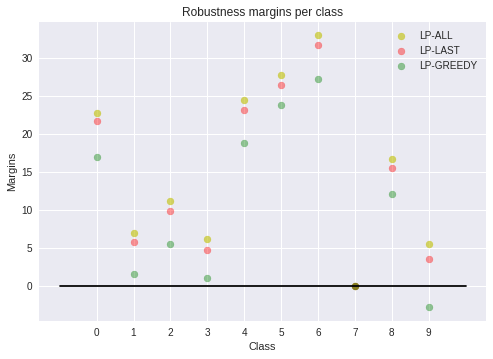

In [20]:
def lp_all(net, x, epsilon=epsilon):
    y_pred = net(x).max(1)[1]
    sample = x.flatten().numpy()
    C = np.eye(n_classes)[y_pred] - np.eye(n_classes)

    affine, biases = init_affine(net, x)
    num_linear_layers = len(affine)

    # Get the weights and biases from the network. Will be used in the LP formulation later. 
    W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
    b = [bias.view(-1).cpu().data.numpy() for bias in biases]

    zl = [[] for i in range(num_linear_layers)]
    zu = [[] for i in range(num_linear_layers)]

    for k in range(num_linear_layers):
        z = [cp.Variable(l.in_features) for l in affine[:k+1]]
        zhat = [cp.Variable(l.out_features) for l in affine[:k+1]]

        # Constraints of the LP
        cons_eq = [zhat[i] == W[i]@z[i] + b[i] for i in range(k+1)]
        cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
        cons_zero = [z[i] >= 0 for i in range(1,k+1)]
        cons_linear = [z[i+1] >= zhat[i] for i in range(k)]
        cons_upper = [(cp.multiply(-(np.maximum(zu[i],0) - np.maximum(zl[i], 0)), zhat[i]) +
                        cp.multiply((zu[i] - zl[i]), z[i+1]) <= 
                        zu[i]*np.maximum(zl[i],0) - zl[i]*np.maximum(zu[i],0)) for i in range(k)]
        cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_upper

        margins_lp_all = []
        for node_idx in range(affine[k].out_features):
            if k == num_linear_layers-1:
                if node_idx == y_pred.item():
                    margins_lp_all.append(0)
                    continue
                f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]@zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS)
                margins_lp_all.append(f_primal_1)
            else:
                f_primal_1 = cp.Problem(cp.Minimize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
                f_min = zhat[-1][node_idx].value
                zl[k].append(f_min)

                f_primal_2 = cp.Problem(cp.Maximize(zhat[-1][node_idx]), cons).solve(verbose=False, solver=cp.ECOS)
                f_max = zhat[-1][node_idx].value
                zu[k].append(f_max)
        zl[k] = np.array(zl[k])
        zu[k] = np.array(zu[k])
    return(margins_lp_all)

start = time()
margins_lp_all = lp_all(net, x)
times.append(time() - start)
print(f"CPU time: {times[-1]:.3f} s")

plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.4, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('Robustness margins per class')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_lp_all)>=0):
    print('Robustness certified for epsilon={} using LP-ALL'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using LP-ALL'.format(epsilon))

MILP[12]:

We have tried to run the MILP algorithm but it takes more than an hour and returned abnormal values (infinite, or very negative). Unfortunately its long running time prevented us from being able to debug it.

In [ ]:
def milp(net, x, epsilon=epsilon):
    y_pred = net(x).max(1)[1]
    sample = x.flatten().numpy()
    C = np.eye(num_classes)[y_pred] - np.eye(num_classes)

    affine, biases = init_affine(net, X)
    num_linear_layers = len(affine)

    W = [l(Variable(torch.eye(l.in_features))).t().cpu().data.numpy() for l in affine]
    b = [bias.view(-1).cpu().data.numpy() for bias in biases]

    margins_milp = []
    z = [cp.Variable(l.in_features) for l in affine[:num_linear_layers]]
    zhat = [cp.Variable(l.out_features) for l in affine[:num_linear_layers]]
    a = [cp.Variable(l.out_features, boolean=True) for l in affine[:num_linear_layers]]

    # These MILP constraints can be found in the formulation presented 
    # in Appendix A.1 of Tjeng et. al., 2019 (https://arxiv.org/abs/1711.07356)
    cons_eq = [zhat[i] == W[i]*z[i] + b[i] for i in range(num_linear_layers)]
    cons_ball = [z[0] >= sample - epsilon, z[0] <= sample + epsilon, z[0] >= 0, z[0] <= 1.0]
    cons_zero = [z[i] >= 0 for i in range(1,num_linear_layers)]
    cons_linear = [z[i+1] >= zhat[i] for i in range(num_linear_layers-1)]
    cons_milp_1 = [z[i+1] <= cp.multiply(zu[i],a[i]) for i in range(num_linear_layers-1)]
    cons_milp_2 = [z[i+1] <= zhat[i] - cp.multiply(zl[i],(1 - a[i])) for i in range(num_linear_layers-1)]

    cons = cons_eq + cons_ball + cons_zero + cons_linear + cons_milp_1 + cons_milp_2

    for node_idx in range(affine[num_linear_layers-1].out_features):
        if node_idx == y_pred.item():
            margins_milp.append(0)
            continue
        f_primal_1 = cp.Problem(cp.Minimize(C[node_idx]*zhat[-1]), cons).solve(verbose=False, solver=cp.ECOS_BB)
        margins_milp.append(f_primal_1)
    return(margins_milp)

start = time()
margins_milp = milp(net, x)
times.append(time() - start)
print(f"CPU time: {times[-1]}:.3f")

plt.scatter([i for i in range(10)], margins_milp, label='MILP')
plt.scatter([i for i in range(10)], margins_lp_all, color='y', alpha=0.6, label='LP-ALL')
plt.scatter([i for i in range(10)], margins_lp_last, color='r', alpha=0.4, label='LP-LAST')
plt.scatter([i for i in range(10)], margins_lp_greedy, color='g', alpha=0.2, label='LP-GREEDY')
plt.plot([-1,10],[0,0], color='k')
plt.legend()
plt.title('robustness is certified if all margins are positive')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
if np.all(np.array(margins_milp)>=0):
    print('Robustness certified for epsilon={} using MILP'.format(epsilon))
else:
    print('Robustness NOT certified for epsilon={} using MILP'.format(epsilon))

CPU time comparison of the algorithms (for MILP the running time is approximately 4000s from our tests)

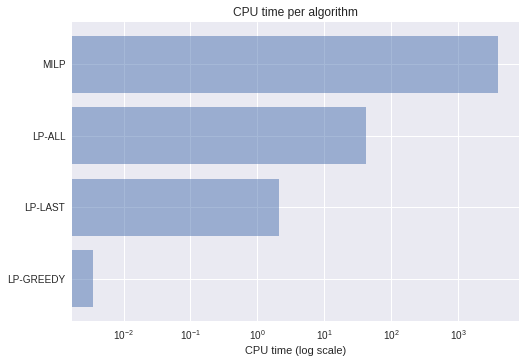

In [30]:
fig, ax = plt.subplots()
algos = ["LP-GREEDY","LP-LAST","LP-ALL","MILP"]
times.append(4000)
y_pos = np.arange(len(algos))
plt.barh(y_pos, times, align='center', alpha=0.5)
plt.yticks(y_pos, algos)
plt.xlabel('CPU time (log scale)')
plt.title('CPU time per algorithm')
ax.set_xscale('log')
plt.show()

LP-GREEDY is very fast, while LP-LAST and LP-ALL have reasonable running time and MILP takes too long. Note that here we used a small NN. For neural networks used in real applications (with millions of neurons) only LP-GREEDY would be usable.

Comparison of the margin values for the 3 relaxed verifiers over 100 inputs:

In [39]:
l_x, l_y = [],[]
for _ in range(100):
    x, y = next(test_loader_iter)
    l_x.append(x)
    l_y.append(y)

In [42]:
lp_greedy_margins = Parallel(n_jobs=12)(delayed(lp_greedy)(net, x, epsilon) for x in l_x)

In [43]:
lp_last_margins = Parallel(n_jobs=12)(delayed(lp_last)(net, x, epsilon) for x in l_x)

In [48]:
lp_all_margins = Parallel(n_jobs=12)(delayed(lp_all)(net, x, epsilon) for x in l_x)

In [59]:
from matplotlib.transforms import Affine2D

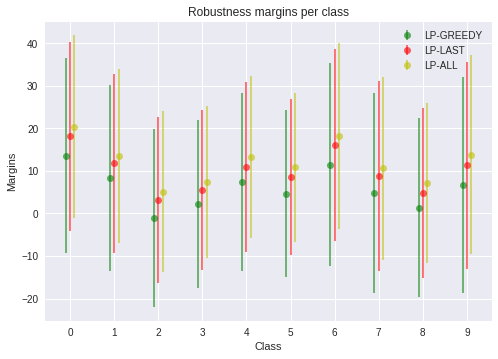

In [65]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
plt.errorbar(
    range(10), np.mean(lp_greedy_margins, axis=0), yerr=np.std(lp_greedy_margins, axis=0), fmt='o',
    label="LP-GREEDY", transform=trans1, color='g', alpha=0.6,)
plt.errorbar(
    range(10), np.mean(lp_last_margins, axis=0), yerr=np.std(lp_last_margins, axis=0), fmt='o',
    label="LP-LAST", color='r', alpha=0.6,)
plt.errorbar(
    range(10), np.mean(lp_all_margins, axis=0), yerr=np.std(lp_all_margins, axis=0), fmt='o',
    label="LP-ALL", transform=trans2, color='y', alpha=0.6,)
plt.title('Robustness margins per class')
plt.ylabel('Margins')
plt.xlabel('Class')
plt.xticks([i for i in range(10)])
plt.legend()

How many of the 100 samples are certified to be robust (for $\varepsilon=0.025$) by each verifier?

In [69]:
print("LP-GREEDY: ", np.sum([verify(lp_greedy_margins[i]) for i in range(100)]))
print("LP-LAST: ", np.sum([verify(lp_last_margins[i]) for i in range(100)]))
print("LP-ALL: ", np.sum([verify(lp_all_margins[i]) for i in range(100)]))

LP-GREEDY:  28
LP-LAST:  33
LP-ALL:  36


The optimal relaxation LP-ALL discovered 29% more robust samples than commonly-used verifiers like LP-GREEDY. However, considering that it takes ~12000 times longer to run (in this example), and that it was proven in the paper's experiments that it still suffers the barrier problem, we can conclude that greedy solvers are good enough for most applications.

Example of computation of a lower bound on $\varepsilon_x$ (maximum epsilon for which robustness is certified, i.e. maximum radius of perturbations that do not change the output of the NN):

In [75]:
# using LP-GREEDY
epsilon = 0.2
while not(verify(lp_greedy(net, x, epsilon))):
    epsilon *= 0.9
print(f"{epsilon:.3f}")

0.014


-> This sample is certified to be robust for $\varepsilon=0.014$.

In [76]:
# using LP-LAST
epsilon = 0.2
while not(verify(lp_last(net, x, epsilon))):
    epsilon *= 0.9
print(f"{epsilon:.3f}")

0.014


### Conclusion

The authors of this paper present a framework that covers most of the recent works on convex relaxation of the neural network verification problem, and empirically prove through large-scale experiments that there exists a barrier that prevents such relaxations from achieving tight bounding of the robust error. Although we didn't have the time and compute necessary to reproduce the paper's results, our experiment results were in line with the results provided in the paper and allowed us to evaluate the running time and the performance of the studied algorithms.

# References
[1] Burak Bartan, Mert Pilanci. Convex Relaxations of Convolutional Neural Nets. IEEE ICASSP 2019.

[2] Hadi Salman, Greg Yang, Huan Zhang, Cho-Jui Hsieh, Pengchuan Zhang. A Convex Relaxation Barrier to Tight Robustness Verification of Neural Networks. NeurIPS 2019.

[3] Guy Katz, Clark Barrett, David L Dill, Kyle Julian, and Mykel J Kochenderfer. Reluplex: An efficient smt solver for verifying deep neural networks. In International Conference on Computer Aided Verification, pages 97–117. Springer, 2017.

[4] Tsui-Wei Weng, Huan Zhang, Hongge Chen, Zhao Song, Cho-Jui Hsieh, Duane Boning, Inderjit SDhillon, and Luca Daniel. Towards fast computation of certified robustness for ReLU networks. In International Conference on Machine Learning, 2018.

[5] Gagandeep Singh, Timon Gehr, Matthew Mirman, Markus Püschel, and Martin Vechev.  Fast andeffective robustness certification. In Advances in Neural Information Processing Systems, pages 10825–10836, 2018.

[6] Shiqi Wang, Kexin Pei, Justin Whitehouse, Junfeng Yang, and Suman Jana. Efficient formal safety analysis of neural networks.   In Advances in Neural Information Processing Systems, pages 6369–6379, 2018b.

[7] Huan Zhang, Tsui-Wei Weng, Pin-Yu Chen, Cho-Jui Hsieh, and Luca Daniel. Efficient neural network robustness certification with general activation functions.  In Advances in Neural InformationP rocessing Systems (NIPS), dec 2018.

[8] Gagandeep Singh, Timon Gehr, Markus Püschel, and Martin Vechev. An abstract domain for certifying neural networks.Proceedings of the ACM on Programming Languages, 3(POPL):41

[9] Eric Wong and Zico Kolter.  Provable defenses against adversarial examples via the convex outer adversarial polytope. In International Conference on Machine Learning (ICML), pages 5283–5292,2018

[10] Huan Zhang, Tsui-Wei Weng, Pin-Yu Chen, Cho-Jui Hsieh, and Luca Daniel. Efficient neural network robustness certification with general activation functions.  In Advances in Neural InformationProcessing Systems (NIPS), 2018.

[11] Aleksander Madry, Aleksandar Makelov, Ludwig Schmidt, Dimitris Tsipras, and Adrian Vladu. Towards deep learning models resistant to adversarial attacks.arXiv preprint arXiv:1706.06083,2017.

[12] Vincent Tjeng, Kai Y. Xiao, and Russ Tedrake. Evaluating robustness of neural networks with mixed integer programming.  In International Conference on Learning Representations, 2019.